# Setup

## Librerías, modulos y configuración de la notebook 

In [1]:
#!pip install catboost

In [2]:
#### Librerías y modulos ####
import pandas as pd
import numpy as np
import seaborn as sns
import os,json
import matplotlib.pyplot as plt
import sklearn
from pandas.io import gbq
from datetime import datetime
import warnings
from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from catboost import CatBoostRegressor
import sys
sys.path.insert(0, os.path.join(os.path.dirname(os.getcwd()),'src/'))
from funcs_cotizador import *

In [3]:
#### Configuraciones de la notebook ####
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)
#pd.set_option('display.width', 1000)
pd.set_option('display.float_format', lambda x: '%.2f' % x)
warnings.filterwarnings("ignore")

In [4]:
#### Parametros de la notebook ####
path_save = '../datos/'
# actualizado al 04/19
dolar_blue = 197
dolar_oficial = 119.28

## Load data

In [5]:
# Upload del pickle generado en la notebook "make_data"
df = pd.read_pickle('{}df_meli_2022-05-04.pkl'.format(path_save))

In [6]:
df.shape

(832016, 42)

In [7]:
df.dtypes

runtime             datetime64[ns, UTC]
date                             dbdate
timestamp           datetime64[ns, UTC]
date_hour                datetime64[ns]
price_symbol                     object
price_amount_txt                 object
price_amount                    float64
car_year                          Int64
car_kms_txt                      object
car_kms                         float64
km                              boolean
car_title                        object
car_location                     object
car_location_0                   object
car_location_1                   object
car_link                         object
car_id                           object
year                              Int64
brand                            object
model                            object
version                          object
dealer                          boolean
match_marca_a                    object
score_marca_a                     Int64
match_modelo_a                   object


# Data Cleaning/Preprocessing 

### *Eliminar nulos*

In [8]:
old_shape = df.shape[0]
df = df.dropna(subset=['car_year','car_kms','match_marca_a','match_modelo_a','match_v1_a','Subseg_a', 'Seg_a'])
print(f'Hey! {old_shape - df.shape[0]} were removed due to null values')
old_shape = df.shape[0]

Hey! 1011 were removed due to null values


### *Eliminar duplicados*

In [9]:
# Tratamiento de la feautre "runtime"
df['runtime'] = pd.to_datetime(df.runtime.apply(lambda x: str(x)[:19]))
df = df.sort_values(['runtime'])
# Ahora si, teniendo el df ordenado, eliminamos los duplicados, quedandonos con el registro más reciente (la última ocurrencia)
df.drop_duplicates(subset=['car_id'], keep='last', inplace=True)

In [10]:
df.shape

(129823, 42)

### *Eliminar 11111 & 999999*

**Dropeamos valores como 111111 o 999999 (ya sean outliers o no)** --> ESTO HAY QUE SUMARLO AL PROCESAMIENTO DE LAS SIMULACIONES !!! <br> 
* Pueden existir casos donde estos valores extraños no sean outliers, por lo tanto no los vamos a conseguir limpiar cuando dropiemos outliers. Es por eso que desarrollamos el siguiente metodo
* Es clave hacerlo en este momento sobre "price_amount" y no luego sobre "price_meli_ok" ya que hay casos en los que el price simbol es USD y luego cuando lo multiplicamos por el TC para pasar a "price_meli_ok" dejan de cumplir estas condiciones de ser 111111 o 999999 y les perdemos el rastro

In [11]:
df['price_amount'] = df.price_amount.astype('int')

In [12]:
m1 = df.price_amount == 1111
m2 = df.price_amount == 11111
m3 = df.price_amount == 111111
m4 = df.price_amount == 1111111
m5 = df.price_amount == 11111111
m6 = df.price_amount == 111111111

len(df[m1 | m2 | m3 | m4 | m5 | m6])

42

In [13]:
# observamos
df[m1 | m2 | m3 | m4 | m5 | m6][['price_amount']].head()

,price_amount
3858,11111111
255717,11111111
212540,111111111
102200,1111111
29468,111111111


In [14]:
df.shape

(129823, 42)

In [15]:
# dropeamos
df = df[~(m1 | m2 | m3 | m4 | m5 | m6)]

In [16]:
df.shape

(129781, 42)

*Ahora lo mismo pero para los casos 999999*

In [17]:
m1 = df.price_amount == 9999
m2 = df.price_amount == 99999
m3 = df.price_amount == 999999
m4 = df.price_amount == 9999999
m5 = df.price_amount == 99999999

len(df[m1 | m2 | m3 | m4 | m5])

87

In [18]:
# observamos
df[m1 | m2 | m3 | m4 | m5 | m6][['price_amount']].head()

,price_amount
5973,99999999
89773,9999999
103868,999999
42914,999999
31525,9999999


In [19]:
df.shape

(129781, 42)

In [20]:
# dropeamos
df = df[~(m1 | m2 | m3 | m4 | m5)]

In [21]:
df.shape

(129694, 42)

*Ahora lo mismo para kms*

In [22]:
df['car_kms'] = df.car_kms.astype('int')

In [23]:
df[df.car_kms > 0]['car_kms'].min()

1

In [24]:
m1 = df.car_kms == 1
m2 = df.car_kms == 11
m3 = df.car_kms == 111
m4 = df.car_kms == 1111
m5 = df.car_kms == 11111
m6 = df.car_kms == 111111
m7 = df.car_kms == 1111111
m8 = df.car_kms == 11111111

len(df[ m1 | m2 | m3 | m4 | m5 | m6 | m7 | m8])

806

In [25]:
# observamos
df[m1 | m2 | m3 | m4 | m5 | m6 | m7 | m8][['car_kms']].head()

,car_kms
2799,1111
1177,111111
7810,11111
8492,11111
211741,111111


In [26]:
df.shape

(129694, 42)

In [27]:
# dropeamos
df = df[~(m1 | m2 | m3 | m4 | m5 | m6 | m7 | m8)]

In [28]:
df.shape

(128888, 42)

*Lo mismo pero para los valores 99999*

In [29]:
m1 = df.car_kms == 999
m2 = df.car_kms == 9999
m3 = df.car_kms == 99999
m4 = df.car_kms == 999999
m5 = df.car_kms == 9999999

len(df[m1 | m2 | m3 | m4 | m5])

77

In [30]:
# observamos
df[m1 | m2 | m3 | m4 | m5][['car_kms']].head()

,car_kms
252610,99999
252092,999
17358,999999
80507,999999
90932,999999


In [31]:
df.shape

(128888, 42)

In [32]:
# dropeamos
df = df[~(m1 | m2 | m3 | m4 | m5)]

In [33]:
df.shape

(128811, 42)

In [34]:
# checkpoint
df.to_csv('{}df_checkpoint_1.pkl'.format(path_save))

In [35]:
df = pd.read_csv('{}df_checkpoint_1.pkl'.format(path_save))
df.shape

(128811, 43)

### *Precio final*

In [36]:
#Dropeamos los precios en dolares** --> Al final no lo hicimos
#Representan un 14% de la base !!! Caía mucho el test sin estos casos
# observamos su volumen
mask = df.price_symbol == 'U$S'
display(df[mask].shape)
display(round(df[mask].shape[0]/len(df),2))
# dropeamos
df.drop(list(df[mask].index),axis=0,inplace=True)
display(df.shape)

(14614, 43)

0.11

(114197, 43)

In [37]:
df.rename(columns={'price_amount':'price_meli_ok'},inplace=True)

In [38]:
# # Construcción del precio final
# blue= dolar_blue
# oficial= dolar_oficial
# col1 = 'price_symbol'
# col2 = 'car_kms'
# conditions = [df[col1]!='U$S', (df[col1]=='U$S') & (df[col2]==0), (df[col1]=='U$S') & (df[col2]!=0)]
# choices = [df.price_amount, df['price_amount']*oficial, df['price_amount']*blue]

# df['price_meli_ok'] = np.select(conditions, choices, default=np.nan)

### *Dropeamos 0kms y concesionaria*

In [39]:
df['dealer'] = np.where(df['dealer']==True,1,0)
mask_not_0km = df.car_kms > 90
mask_not_conces = df.dealer == 0

df = df[(mask_not_0km) & (mask_not_conces)]

In [40]:
df.shape

(49961, 43)

### *Dropeamos match_score por debajo de 80%*

In [41]:
lst = ['score_marca_a','score_modelo_a','score_v1_c']
for col in lst:
    df = df[df[col]>=80]
    
# chequeo
df[lst].min()

score_marca_a     92
score_modelo_a    86
score_v1_c        80
dtype: int64

In [42]:
df.shape

(40332, 43)

### *Dropeamos registros que no sean de los ultimos 15 días*

In [43]:
df.runtime.max()

'2022-04-18 23:01:25'

In [44]:
from datetime import date, datetime, timedelta

In [45]:
df['runtime'] = df['runtime'].apply(pd.to_datetime)

In [46]:
df[['runtime','price_meli_ok']].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 40332 entries, 2 to 128810
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   runtime        40332 non-null  datetime64[ns]
 1   price_meli_ok  40332 non-null  int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 945.3 KB


In [47]:
max_date = df.runtime.max()
mask_last15d = (df.runtime <= max_date) & ((df.runtime >= max_date - timedelta(days=15)))
df = df[mask_last15d]

In [48]:
df.runtime.max()

Timestamp('2022-04-18 23:01:25')

In [49]:
print(df.runtime.min())
print(df.runtime.max())

2022-04-04 00:00:30
2022-04-18 23:01:25


In [50]:
df.shape

(37713, 43)

### *Dropeamos categorías que no nos sirven*

*Las categorías que dejamos afuera, son las que no nos interesa cotizar porque irán a reglas o al equipo de pricing*

Los grupos de los escenarios los vamos a re-definir aca. Debido a que cuando lo hicimos en la nb "Tres escenarios" como un primer apporach estaba bien y aparte el objetivo era validar la hipotesis de outliers vs presencia. Pero ocurre que aca el procesamiento es más profundo, y por lo tanto un auto que capas estaba en el grupo 4 en la nb "Tres Escenarios" aca debido a las limpiezas extra respesto a esa nb, pierden muchisimo volumen y quedaría en grupos muchísimos más bajos que no entrarían para el algoritmo. El caso perfecto es la F-150 de FORD: en ese caso en la nb "Tres Esce" quedaba en el grupo 4, y aca desp de todo el procesamiento nos queda 1 solo caso el cual se nos fue a test despues de split y en train no estaba, por lo tanto tira error la funcion de data_processing_1().

In [51]:
df_grouped = df.groupby(['match_marca_a','match_modelo_a','match_v1_a'],as_index=False).size()
df_grouped.columns = ['marca','modelo','version','cant']
df_grouped.sort_values(by='cant',ascending=False,inplace=True)

In [52]:
df_grouped.head(10)

,marca,modelo,version,cant
1810,VOLKSWAGEN,Gol Trend,1.6 MSI 5Ptas. Trendline (101cv) (L17),388
1218,PEUGEOT,308,Allure 1.6 HDI NAV (115cv) 5Ptas. (L16),378
1768,VOLKSWAGEN,Gol,1.6 3Ptas. Power,356
1420,RENAULT,Kangoo,1.6 Expression / Confort AA LV2 TRF 2ABG RACK ...,312
1799,VOLKSWAGEN,Gol Trend,1.6 3Ptas. Trendline / Pack I (101cv),259
1166,PEUGEOT,208,1.6 N 16v Feline Tiptronic (115cv) (L18),256
707,FORD,Fiesta,1.6 Titanium Powershift (120cv) 5Ptas.,252
1617,TOYOTA,Corolla,XEI 1.8 CVT (140cv) (L18),235
1732,VOLKSWAGEN,Bora,2.0 Trendline MT,215
1674,TOYOTA,Hilux,4x4 CD SRX 2.8 TDI 6MT (177cv) (L16),205


In [53]:
df_grouped.tail(10)

,marca,modelo,version,cant
1116,PEUGEOT,206,5Ptas. 1.4 RWC - Serie Limitada,1
1119,PEUGEOT,206,5Ptas. 1.6 XR Premium Tiptronic,1
1120,PEUGEOT,206,5Ptas. 1.6 XT,1
1123,PEUGEOT,206,5Ptas. 1.9d RWC - Serie Limitada,1
1130,PEUGEOT,206,SW Escapade 1.6,1
1131,PEUGEOT,206,SW Premiun 1.6,1
1132,PEUGEOT,206,SW Quiksilver,1
1146,PEUGEOT,207,Compact 5Ptas. 1.9D XT (70cv),1
1164,PEUGEOT,208,1.6 N 16v Feline (115cv),1
1992,VOLVO,XC60,T6 AWD High Luxury R-Design (304hp),1


In [54]:
mask = df_grouped['marca'] == 'VOLKSWAGEN'
df_grouped[mask].sort_values(by='modelo')

,marca,modelo,version,cant
1723,VOLKSWAGEN,Amarok,2.0 TDI (180cv) 4x4 C/Doble Startline,2
1728,VOLKSWAGEN,Amarok,3.0 TDI V6 (224cv) 4x4 C/Doble Extreme AT (L17),79
1699,VOLKSWAGEN,Amarok,2.0 TDI (140cv) 4x4 C/Simple Startline,21
1703,VOLKSWAGEN,Amarok,2.0 TDI (163cv) 4x4 C/Doble Highline Black,1
1713,VOLKSWAGEN,Amarok,2.0 TDI (180cv) 4x2 C/Doble Startline,23
1716,VOLKSWAGEN,Amarok,2.0 TDI (180cv) 4x4 C/Doble Black Edition AT,4
1718,VOLKSWAGEN,Amarok,2.0 TDI (180cv) 4x4 C/Doble Comfortline AT (L1...,4
1702,VOLKSWAGEN,Amarok,2.0 TDI (163cv) 4x2 C/Doble Trendline,24
1695,VOLKSWAGEN,Amarok,2.0 TDI (140cv) 4x2 C/Doble Trendline (L17),1
1707,VOLKSWAGEN,Amarok,2.0 TDI (180cv) 4x2 C/Doble Comfortline (L17),64


In [55]:
# agrupacion
df_grouped = df.groupby(['match_marca_a','match_modelo_a','match_v1_a'],as_index=False).size()
df_grouped.columns = ['marca','modelo','version','cant']
df_grouped.sort_values(by='cant',ascending=False,inplace=True)

# deciles
df_output = df_grouped.copy()

data = df_grouped.copy()
data.sort_values(by='cant',ascending=False,inplace=True)

data['cuantiles' + str('_'+'cant')] =pd.qcut(data['cant'], 10, duplicates='drop')

placeholder= 'marca'
tmp = data.groupby('cuantiles' + str('_'+'cant')).agg({placeholder:'count'}).rename(columns={placeholder:'placeholder'})
leni = len(tmp)
tmp['cuantil' + str('_'+'cant')] = list(reversed(list(np.arange(1,leni+1,1))))
tmp['bin' + str('_'+'cant')] = tmp.index
tmp.reset_index(drop=True,inplace=True)
tmp.drop('placeholder',1,inplace=True)

data = data.merge(tmp, how='inner',left_on=['cuantiles' + str('_'+'cant')], right_on='bin' + str('_'+'cant'))

#data.drop(cols_to_drop,1,inplace=True)

#df_output = df_output.merge(data, on=['marca','modelo','version'])

# seleccion y orden final de las columnas del output
#df_output_ok = df_output[['marca','modelo','version','cant','cuantil_cant','bin_cant']]
#df_output_ok.sort_values(by='cant',ascending=False,inplace=True)
#df_output_ok.head()

In [56]:
data.drop('cuantiles_cant',1,inplace=True)

In [57]:
data.version.nunique()

1835

In [58]:
asd = (data.groupby('cuantil_cant')['cant'].sum()/sum(data.cant))*100
asd

cuantil_cant
1   54.72
2   19.86
3   10.40
4    4.77
5    4.17
6    2.44
7    1.35
8    2.29
Name: cant, dtype: float64

In [59]:
tmp

,cuantil_cant,bin_cant
0,8,"(0.999, 2.0]"
1,7,"(2.0, 3.0]"
2,6,"(3.0, 5.0]"
3,5,"(5.0, 9.0]"
4,4,"(9.0, 13.0]"
5,3,"(13.0, 25.0]"
6,2,"(25.0, 55.0]"
7,1,"(55.0, 388.0]"


In [60]:
# Escenario de cotizacion: Algoritmo
print(f'Algoritmo: {asd.iloc[0:4].sum()}')
print(f'Reglas: {asd.iloc[4:7].sum()}')
print(f'Equipo Pricing: {asd.iloc[7:].sum()}')

Algoritmo: 89.7541961657784
Reglas: 7.957468247023574
Equipo Pricing: 2.2883355871980484


In [61]:
# Marcas-modelos en cada grupo
data['marca_modelo_version'] = data['marca'] + str(' - ') +data['modelo'] + str(' - ') + data['version']
data.head()

,marca,modelo,version,cant,cuantil_cant,bin_cant,marca_modelo_version
0,VOLKSWAGEN,Gol Trend,1.6 MSI 5Ptas. Trendline (101cv) (L17),388,1,"(55.0, 388.0]",VOLKSWAGEN - Gol Trend - 1.6 MSI 5Ptas. Trendl...
1,PEUGEOT,308,Allure 1.6 HDI NAV (115cv) 5Ptas. (L16),378,1,"(55.0, 388.0]",PEUGEOT - 308 - Allure 1.6 HDI NAV (115cv) 5Pt...
2,VOLKSWAGEN,Gol,1.6 3Ptas. Power,356,1,"(55.0, 388.0]",VOLKSWAGEN - Gol - 1.6 3Ptas. Power
3,RENAULT,Kangoo,1.6 Expression / Confort AA LV2 TRF 2ABG RACK ...,312,1,"(55.0, 388.0]",RENAULT - Kangoo - 1.6 Expression / Confort AA...
4,VOLKSWAGEN,Gol Trend,1.6 3Ptas. Trendline / Pack I (101cv),259,1,"(55.0, 388.0]",VOLKSWAGEN - Gol Trend - 1.6 3Ptas. Trendline ...


In [62]:
data[data.modelo == 'Tiggo']

,marca,modelo,version,cant,cuantil_cant,bin_cant,marca_modelo_version
128,CHERY,Tiggo,2.0 16v 4x2 Confort (138cv),72,1,"(55.0, 388.0]",CHERY - Tiggo - 2.0 16v 4x2 Confort (138cv)
648,CHERY,Tiggo,2.0 16v 4x4 Luxury (138cv),12,4,"(9.0, 13.0]",CHERY - Tiggo - 2.0 16v 4x4 Luxury (138cv)
1121,CHERY,Tiggo,2.0 16v 4x2 Luxury AT (138cv),4,6,"(3.0, 5.0]",CHERY - Tiggo - 2.0 16v 4x2 Luxury AT (138cv)


In [63]:
len(data) == data.marca_modelo_version.nunique()

True

In [64]:
print('asd')

asd


In [65]:
# Marcas-modelo-versiones en cada grupo
sorted(list(data[data['cuantil_cant']==1]['marca_modelo_version'].unique()))

['CHERY - Tiggo - 2.0 16v 4x2 Confort (138cv)',
 'CHEVROLET - Agile - 1.4 LS / LS Spirit 5Ptas.',
 'CHEVROLET - Agile - 1.4 LT / LT Spirit 5Ptas.',
 'CHEVROLET - Astra II - GL 2.0 8v',
 'CHEVROLET - Astra II - GLS 2.0 16v',
 'CHEVROLET - Aveo - LT 1.6 AT 4Ptas. (103cv)',
 'CHEVROLET - Celta - 1.4 N 8v LS AA DA (92cv) 3Ptas. (L13)',
 'CHEVROLET - Classic - 4Ptas. 1.4 N LS ABS ABC',
 'CHEVROLET - Classic - 4Ptas. 1.4 N LT Spirit Pack',
 'CHEVROLET - Classic - 4Ptas. 1.4 N Spirit / LS AA DA',
 'CHEVROLET - Corsa II - 5Ptas. 1.8 Nafta GL AA DA',
 'CHEVROLET - Corsa II - GSI 2.4 16v 5Ptas.',
 'CHEVROLET - Cruze - 1.8 LT MT (141cv) 4Ptas. ',
 'CHEVROLET - Cruze - 1.8 LTZ AT (141cv) 4Ptas. ',
 'CHEVROLET - Cruze - 1.8 LTZ MT (141cv) 4Ptas. ',
 'CHEVROLET - Meriva - 1.8 N 8v GL Plus',
 'CHEVROLET - Onix - 1.4 8v Joy LS MT (Plan) (98cv)',
 'CHEVROLET - Onix - 1.4 8v LT MT (98cv)',
 'CHEVROLET - Onix - 1.4 8v LTZ MT (98cv)',
 'CHEVROLET - Prisma - 1.4 8v LT MT (98cv)',
 'CHEVROLET - Prisma - 1.4

In [66]:
grupos_df = data.copy()
# nos quedamos únicamente con los grupos que entran al modelo
grupos_df_algor = grupos_df[grupos_df['cuantil_cant'].apply(lambda x: x in [1,2,3])] # == 1
# check
grupos_df_algor.cuantil_cant.unique()

array([1, 2, 3])

In [67]:
grupos_df_algor.rename(columns={'cuantil_cant':'grupos'},inplace=True)

In [68]:
grupos_df_algor.head()

,marca,modelo,version,cant,grupos,bin_cant,marca_modelo_version
0,VOLKSWAGEN,Gol Trend,1.6 MSI 5Ptas. Trendline (101cv) (L17),388,1,"(55.0, 388.0]",VOLKSWAGEN - Gol Trend - 1.6 MSI 5Ptas. Trendl...
1,PEUGEOT,308,Allure 1.6 HDI NAV (115cv) 5Ptas. (L16),378,1,"(55.0, 388.0]",PEUGEOT - 308 - Allure 1.6 HDI NAV (115cv) 5Pt...
2,VOLKSWAGEN,Gol,1.6 3Ptas. Power,356,1,"(55.0, 388.0]",VOLKSWAGEN - Gol - 1.6 3Ptas. Power
3,RENAULT,Kangoo,1.6 Expression / Confort AA LV2 TRF 2ABG RACK ...,312,1,"(55.0, 388.0]",RENAULT - Kangoo - 1.6 Expression / Confort AA...
4,VOLKSWAGEN,Gol Trend,1.6 3Ptas. Trendline / Pack I (101cv),259,1,"(55.0, 388.0]",VOLKSWAGEN - Gol Trend - 1.6 3Ptas. Trendline ...


In [69]:
df_grupos = grupos_df_algor[['marca','modelo','version','marca_modelo_version', 'grupos']]

In [70]:
df_grupos

,marca,modelo,version,marca_modelo_version,grupos
0,VOLKSWAGEN,Gol Trend,1.6 MSI 5Ptas. Trendline (101cv) (L17),VOLKSWAGEN - Gol Trend - 1.6 MSI 5Ptas. Trendl...,1
1,PEUGEOT,308,Allure 1.6 HDI NAV (115cv) 5Ptas. (L16),PEUGEOT - 308 - Allure 1.6 HDI NAV (115cv) 5Pt...,1
2,VOLKSWAGEN,Gol,1.6 3Ptas. Power,VOLKSWAGEN - Gol - 1.6 3Ptas. Power,1
3,RENAULT,Kangoo,1.6 Expression / Confort AA LV2 TRF 2ABG RACK ...,RENAULT - Kangoo - 1.6 Expression / Confort AA...,1
4,VOLKSWAGEN,Gol Trend,1.6 3Ptas. Trendline / Pack I (101cv),VOLKSWAGEN - Gol Trend - 1.6 3Ptas. Trendline ...,1
...,...,...,...,...,...
588,CHEVROLET,Corsa II,Wagon 1.4/1.6 N GL,CHEVROLET - Corsa II - Wagon 1.4/1.6 N GL,3
589,CHRYSLER,PT Cruiser,2.4 Touring AutoStick (143cv),CHRYSLER - PT Cruiser - 2.4 Touring AutoStick ...,3
590,RENAULT,Sandero,Fase II 1.6 16v GT Line (105cv),RENAULT - Sandero - Fase II 1.6 16v GT Line (1...,3
591,FORD,Fiesta,5Ptas. 1.6 N Ambiente Plus,FORD - Fiesta - 5Ptas. 1.6 N Ambiente Plus,3


In [71]:
df_grupos.to_csv('{}df_grupos.csv'.format(path_save))

In [72]:
marc_mod_vers_OK = list(df_grupos.marca_modelo_version.unique())
len(marc_mod_vers_OK)

593

In [73]:
pd.Series(marc_mod_vers_OK).to_csv('{}marc_mod_vers_OK.csv'.format(path_save))

In [74]:
# Nos quedamos unicamente con los marca-modelo-version dentro de los grupos 1, 2, 3 y 4
# marcas_ok = list(grupos_df_algor.marca.unique())
# modelos_ok = list(grupos_df_algor.modelo.unique())
# versiones_ok = list(grupos_df_algor.version.unique())
# guardamos las marcas_ok y los modelos_ok ya que son los únicos que nos van a interesar scorear
# pd.Series(marcas_ok).to_csv('{}marcas_ok.csv'.format(path_save))
# pd.Series(modelos_ok).to_csv('{}modelos_ok.csv'.format(path_save))
# pd.Series(versiones_ok).to_csv('{}versiones_ok.csv'.format(path_save))
# mask1 = df.match_marca_a.apply(lambda x: x in marcas_ok)
# mask2 = df.match_modelo_a.apply(lambda x: x in modelos_ok)
# mask3 = df.match_v1_a.apply(lambda x: x in versiones_ok)

old_shape = df.shape
print(old_shape)
df['marca_modelo_version'] = df['match_marca_a'] + str(' - ') +df['match_modelo_a'] + str(' - ') + df['match_v1_a']
mask = df.marca_modelo_version.apply(lambda x: x in marc_mod_vers_OK)
df = df[mask]

df.shape

(37713, 43)


(32050, 44)

In [75]:
sorted(list(df.match_marca_a.unique()))

['AUDI',
 'BMW',
 'CHERY',
 'CHEVROLET',
 'CHRYSLER',
 'CITROEN',
 'DODGE',
 'FIAT',
 'FORD',
 'HONDA',
 'HYUNDAI',
 'JEEP',
 'KIA',
 'MERCEDES BENZ',
 'NISSAN',
 'PEUGEOT',
 'RENAULT',
 'SUZUKI',
 'TOYOTA',
 'VOLKSWAGEN']

In [76]:
# cats_loc1_ok = ['Capital Federal','Bs.As. G.B.A. Sur','Bs.As. G.B.A. Norte'
#            ,'Bs.As. G.B.A. Oeste','Buenos Aires Interior','Bs.As. Costa Atlántica']
# mask1 = df.car_location_1.apply(lambda x: x in cats_loc1_ok)
# cats_brand_ok =['Alfa Romeo','Audi','BMW','Chery','Chevrolet','Citroën','DS','Fiat','Ford','Geely','Haval','Honda',
#  'Hyundai','JAC','Jeep','Kia','Land Rover','Lifan','Mercedes-Benz','Mini','Mitsubishi','Nissan','Peugeot','Porsche','RAM',
#  'Renault','SEAT','Shineray','Smart','Subaru','Suzuki','Toyota','Volkswagen','Volvo'] # Exclusion x pedido Edgar: Dodge, Chrysler
# mask2 = df.brand.apply(lambda x: x in cats_brand_ok)
# sub_mask = df.brand == 'Jeep'
# lst_not_renegade = [i for i in df[sub_mask]['match_modelo_a'].unique() if i != 'Renegade']
# mask3 = df.match_modelo_a.apply(lambda x: x not in lst_not_renegade)
# df = df[(mask1 & mask2 & mask3)]

In [77]:
df.shape

(32050, 44)

### Salvamos el dataset listo para el split

In [78]:
df.to_csv('{}df_checkpoint_2.pkl'.format(path_save))

In [79]:
df = pd.read_csv('{}df_checkpoint_2.pkl'.format(path_save))

In [80]:
df.shape

(32050, 45)

# Split

In [81]:
model_features = ['car_year','car_kms','match_marca_a','match_modelo_a','match_v1_a','match_v1_c', 'Subseg_a', 'Seg_a']
target = ['price_meli_ok']
id_feature = ['car_id']

In [82]:
###### Split #######

X = df[model_features + id_feature]
y = df.price_meli_ok

# 200 bines para discretizar la variable continua
bins = np.linspace(0, len(y), 200)
# Save your Y values in a new ndarray,
# broken down by the bins created above.
y_binned = np.digitize(y, bins)

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.20,  stratify=y_binned,random_state=42)
print(X_train.shape, X_test.shape)

(25640, 9) (6410, 9)


In [83]:
# chequeamos distribuciones del target en ambos dfs
a = pd.concat([y_train.describe(percentiles=[0.001,0.01,0.1,0.25,0.5,0.75,0.9,0.99])
              ,y_test.describe(percentiles=[0.001,0.01,0.1,0.25,0.5,0.75,0.9,0.99])],axis=1)
a.columns = ['price_train','price_test']
a

,price_train,price_test
count,25640.00,6410.00
mean,2404672.80,2409357.72
std,2201341.12,2099777.49
min,210000.00,390000.00
0.1%,500000.00,500000.00
1%,680000.00,670000.00
10%,975000.00,980000.00
25%,1380000.00,1390000.00
50%,1970000.00,1950000.00
75%,2890000.00,2900000.00


<AxesSubplot:xlabel='price_meli_ok', ylabel='Density'>

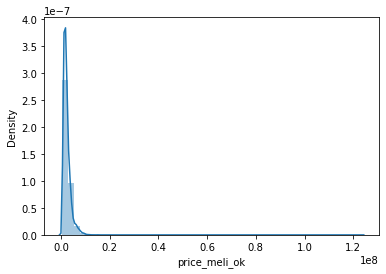

In [84]:
sns.distplot(y_train)

<AxesSubplot:xlabel='price_meli_ok', ylabel='Density'>

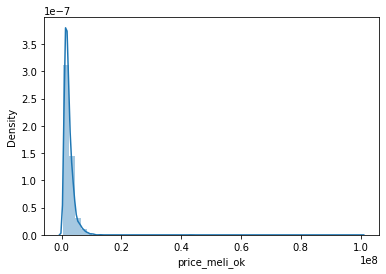

In [85]:
sns.distplot(y_test)

In [86]:
# chequeamos distribuciones de kms en ambos dfs
a = pd.concat([X_train.car_kms.describe(percentiles=[0.005,0.01,0.1,0.25,0.5,0.75,0.9,0.99])
              ,X_test.car_kms.describe(percentiles=[0.005, 0.01,0.1,0.25,0.5,0.75,0.9,0.99])],axis=1)
a.columns = ['kms_train','kms_test']
a

,kms_train,kms_test
count,25640.00,6410.00
mean,109660.28,111200.88
std,78582.11,198794.34
min,103.00,171.00
0.5%,1259.75,1000.00
1%,4000.00,3018.00
10%,31000.00,30000.00
25%,62500.00,62000.00
50%,100000.00,100000.00
75%,145000.00,146000.00


In [87]:
df_train = pd.concat([X_train,y_train],1)
df_test = pd.concat([X_test,y_test],1)

De ahora en más trabajamos solo sobre df_train para evitar data leakage.

In [88]:
del df

### Salvamos los df de train y test

In [89]:
df_train.to_csv('{}df_train_checkpoint_3.pkl'.format(path_save))
df_test.to_csv('{}df_test_checkpoint_3.pkl'.format(path_save))

### *Tratamiento de outliers nº1*

*Vamos a eliminar solamente los outliers más absurdos antes de hacer el split*

In [90]:
model_features = ['car_year','car_kms','match_marca_a','match_modelo_a','match_v1_a','match_v1_c', 'Subseg_a', 'Seg_a']
target = ['price_meli_ok']
id_features = ['runtime','car_id']

In [91]:
df_train.price_meli_ok.describe(percentiles=[0.005, 0.01,0.25,0.75,0.99,0.995,0.998,0.999])

count       25640.00
mean      2404672.80
std       2201341.12
min        210000.00
0.5%       600000.00
1%         680000.00
25%       1380000.00
50%       1970000.00
75%       2890000.00
99%       8000000.00
99.5%     9100000.00
99.8%    10500000.00
99.9%    13180500.00
max     123465234.00
Name: price_meli_ok, dtype: float64

In [92]:
# Asi como aca aparece esta Hilux, este tipo de casos los tratamos en el tratamiento de outliers nº2
df_train[df_train.price_meli_ok <= 250000][model_features]

,car_year,car_kms,match_marca_a,match_modelo_a,match_v1_a,match_v1_c,Subseg_a,Seg_a
3902,2021,960000,FIAT,Cronos,1.3 GSE MT Drive Pack Conectividad (99cv),DRIVE 1.3 MT,Gama Pequenos Sedan,Gama Pequenos
14557,2013,15000,RENAULT,Duster,2.0 4x4 6MT Luxe NAV (138cv),LUXE 2.0 4X4,Suv Compactas 4x2,SUV


In [93]:
df_train.shape

(25640, 10)

<AxesSubplot:xlabel='price_meli_ok'>

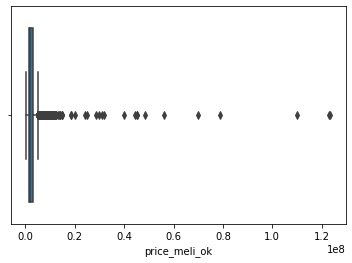

In [94]:
sns.boxplot(df_train.price_meli_ok)

In [95]:
# creamos diccionarios para guardar la info de capeo de outliers
thresh_outliers_1 = {}

In [96]:
# dropmeamos outliers globales de price
p_995 = df_train.price_meli_ok.quantile(0.995)
# guardamos la info de train para luego aplicarla en test
thresh_outliers_1['price_p995'] = p_995
mask = df_train.price_meli_ok <= p_995
df_train = df_train[mask]

<AxesSubplot:xlabel='price_meli_ok'>

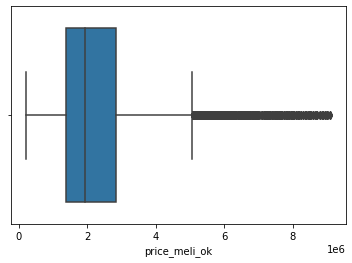

In [97]:
sns.boxplot(df_train.price_meli_ok)

In [98]:
df_train.price_meli_ok.describe(percentiles=[0.001,0.01,0.05,0.1,0.25,0.75,0.99])

count     25513.00
mean    2333647.51
std     1388937.27
min      210000.00
0.1%     500000.00
1%       680000.00
5%       850000.00
10%      970000.00
25%     1380000.00
50%     1950000.00
75%     2850000.00
99%     7500000.00
max     9100000.00
Name: price_meli_ok, dtype: float64

<AxesSubplot:xlabel='price_meli_ok', ylabel='Density'>

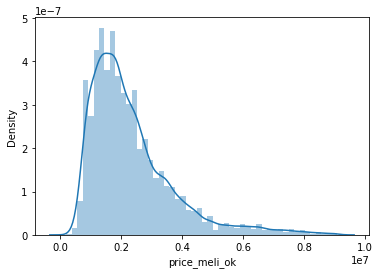

In [99]:
sns.distplot(df_train.price_meli_ok)

In [100]:
# Observamos los casos --> Podemos ver que hay casos como una Kangoo, KA, etc con precios absurdamente altos.
## Casos de este tipo trataremos en el tratamiento de outliers nº2
p_99 = df_train.price_meli_ok.quantile(0.99)
mask = df_train.price_meli_ok >= p_99
df_train[mask][model_features]

,car_year,car_kms,match_marca_a,match_modelo_a,match_v1_a,match_v1_c,Subseg_a,Seg_a
31298,2019,76000,TOYOTA,Hilux,4x4 CD SRX 2.8 TDI 6MT (177cv) (L16),4X4,Pickups Medianas-Grandes,Livianos
2021,2020,27500,VOLKSWAGEN,Amarok,3.0 TDI V6 (224cv) 4x4 C/Doble Comfortline AT ...,DC V6 COMFORTLINE 3.0L TDI 4X4 A,Pickups Medianas-Grandes,Livianos
8518,2021,25400,VOLKSWAGEN,Amarok,2.0 TDI (180cv) 4x4 C/Doble Highline Pack AT,DC 2.0L TDI 180CV HIGHLINE 4X4 AUT EU5,Pickups Medianas-Grandes,Livianos
28615,2021,34000,TOYOTA,Hilux,4x4 CD SR 2.8 TDI 6MT (177cv) (L16),4X4,Pickups Medianas-Grandes,Livianos
28562,2021,4000,TOYOTA,Hilux,4x2 CD SRX 2.8 TDI 6AT (177cv) (L18),4X2/DC,Pickups Medianas-Grandes,Livianos
17166,2021,4000,FORD,Ranger,3.2 TDCi C/Doble 4x4 XLT 6MT (200cv) (L20),XLT 4X4,Pickups Medianas-Grandes,Livianos
10657,2017,125000,TOYOTA,Hilux,4x4 CD SRV 2.8 TDI 6AT Limited (177cv) (L16),4X4,Pickups Medianas-Grandes,Livianos
4755,2021,17800,VOLKSWAGEN,Amarok,2.0 TDI (180cv) 4x4 C/Doble Highline Pack AT,DC 2.0L TDI 180CV HIGHLINE 4X4 AUT EU5,Pickups Medianas-Grandes,Livianos
30837,2020,27000,TOYOTA,Hilux,4x4 CD SR 2.8 TDI 6MT (177cv) (L16),4X4,Pickups Medianas-Grandes,Livianos
27859,2020,40000,FORD,Mondeo,2.0 Ecoboost Titanium AT (240cv) (L15),TITANIUM,Gama Medianos Sedan,Gama Medianos


In [101]:
df_train.shape

(25513, 10)

*Ahora lo mismo pero para kms**

In [102]:
df_train.car_kms.describe(percentiles=[0.005, 0.01,0.25,0.75,0.99,0.995,0.998,0.999])

count     25513.00
mean     109987.90
std       78347.97
min         103.00
0.5%       1739.20
1%         4600.00
25%       63000.00
50%      100194.00
75%      145000.00
99%      300000.00
99.5%    350000.00
99.8%    424880.00
99.9%    554161.28
max     3500000.00
Name: car_kms, dtype: float64

<AxesSubplot:xlabel='car_kms'>

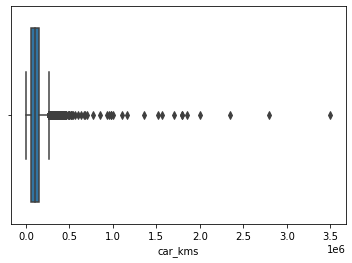

In [103]:
sns.boxplot(df_train.car_kms)

In [104]:
p_995 = df_train.car_kms.quantile(0.995)
# guardamos la info de train para luego aplicarla en test
thresh_outliers_1['kms_p995'] = p_995
mask = df_train.car_kms > p_995
len(df_train[mask])

124

In [105]:
# dropeamos outliers globales de car_kms
df_train = df_train[~mask]

In [106]:
# We are now able to save the dict with the information learned in the train set regarding the thresholds to cap outliers
import json
with open(f'{path_save}thresh_outliers_1.json', 'w') as fp:
    json.dump(thresh_outliers_1, fp)

<AxesSubplot:xlabel='car_kms'>

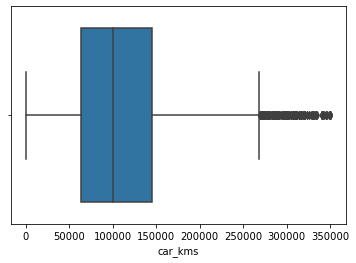

In [107]:
sns.boxplot(df_train.car_kms)

*Revision valores extremos o raros en car_year*

In [108]:
df_train.car_year.describe(percentiles=[0.005, 0.01,0.25,0.75,0.99,0.998,0.999])

count   25389.00
mean     2013.79
std         3.67
min      2006.00
0.5%     2006.00
1%       2006.00
25%      2011.00
50%      2014.00
75%      2017.00
99%      2021.00
99.8%    2021.00
99.9%    2021.00
max      2021.00
Name: car_year, dtype: float64

Vemos que no hay outliers ni casos raros en la variable de año

In [109]:
sorted(df_train.car_year.unique().tolist())

[2006,
 2007,
 2008,
 2009,
 2010,
 2011,
 2012,
 2013,
 2014,
 2015,
 2016,
 2017,
 2018,
 2019,
 2020,
 2021]

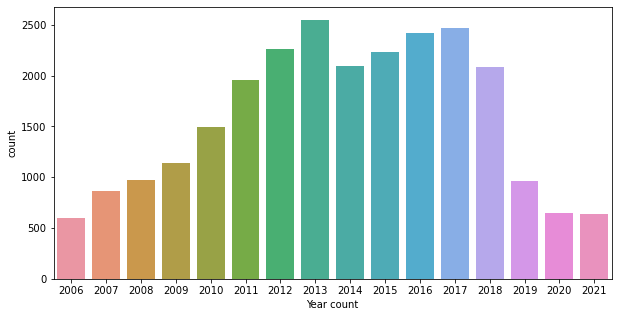

In [110]:
# plot distribution
fig = plt.figure(figsize = (10, 5))
sns.countplot(df_train.car_year)
plt.xlabel("Year count")
plt.show()

In [111]:
df_train['car_year'] = df_train['car_year'].astype('int')

***Fin del tratamiento de outliers nº1***

# Univariado + Bivariado + Cleaning

* Luego volver a correr este bivariado pero sumandole el nivel año a la agregación, luego y hacer una funcion que capee los valores que traspasen los whiskers en cada agrupacion (ej: toyota - hilux - 2020) tanto para km como para precios.
* Usar la version acara en lugarde la de camval
* Mirar los errores en la perfo del modelo, no solo el R2 (la func evaluate que use para airtm)

In [112]:
df_train.columns

Index(['car_year', 'car_kms', 'match_marca_a', 'match_modelo_a', 'match_v1_a',
       'match_v1_c', 'Subseg_a', 'Seg_a', 'car_id', 'price_meli_ok'],
      dtype='object')

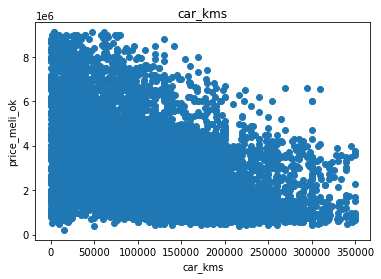

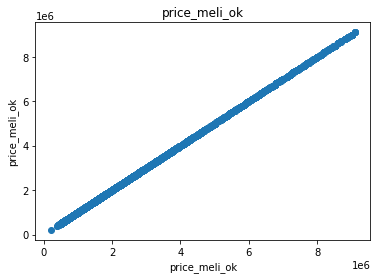

In [113]:
for feature in ['car_kms','price_meli_ok']:
    plt.scatter(df_train[feature],df_train['price_meli_ok'])
    plt.xlabel(feature)
    plt.ylabel('price_meli_ok')
    plt.title(feature)
    plt.show()

In [114]:
mask = df_train.match_marca_a == 'TOYOTA'
data = df_train[mask]
modelos = data.match_modelo_a.unique()
modelos

array(['Corolla', 'Hilux', 'Etios', 'Yaris'], dtype=object)

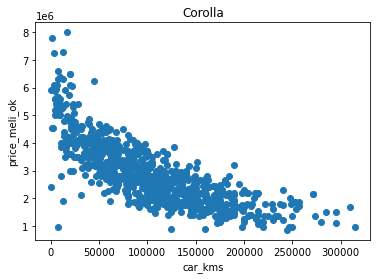

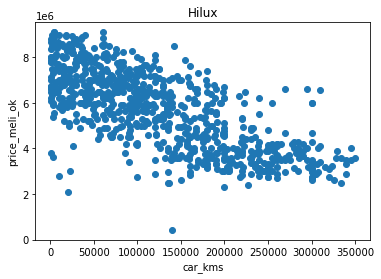

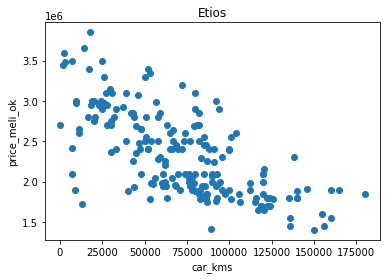

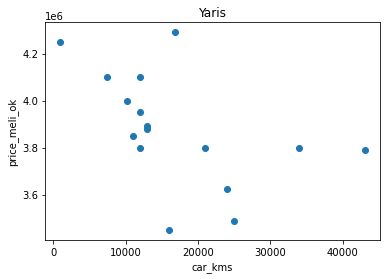

In [115]:
for i in modelos:
    sub_mask = data.match_modelo_a == i
    plt.scatter(data[sub_mask]['car_kms'],data[sub_mask]['price_meli_ok'])
    plt.xlabel('car_kms')
    plt.ylabel('price_meli_ok')
    plt.title(i)
    plt.show()

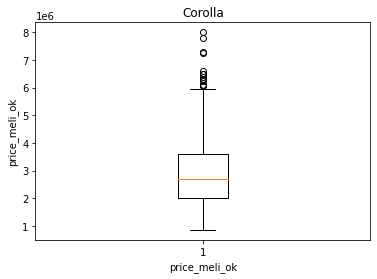

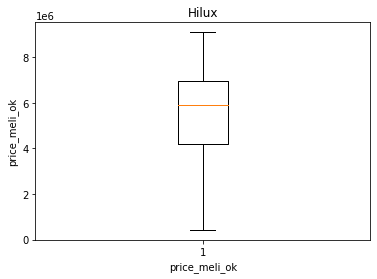

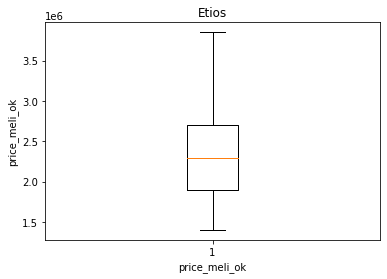

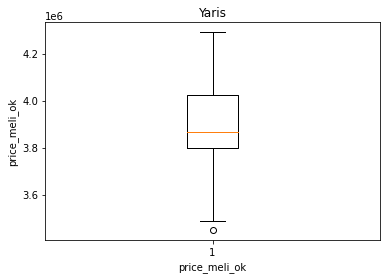

In [116]:
for i in modelos:
    sub_mask = data.match_modelo_a == i
    plt.boxplot(data[sub_mask]['price_meli_ok'])
    plt.xlabel('price_meli_ok')
    plt.ylabel('price_meli_ok')
    plt.title(i)
    plt.show()

Vamos a chequear si los detectamos con la formula q3+1.5*IQR

In [117]:
mask = df_train.match_modelo_a == 'Etios'
data = df_train[mask].copy()
q1 = data.price_meli_ok.quantile(0.25)
q3 = data.price_meli_ok.quantile(0.75)
IQR = q3 - q1
outl_thresh_superior = q3+1.5*IQR
print(outl_thresh_superior)
print(len(data[data.price_meli_ok>=outl_thresh_superior]))

3900000.0
0


In [118]:
mask = df_train.match_modelo_a == 'Hilux'
data = df_train[mask].copy()
q1 = data.price_meli_ok.quantile(0.25)
q3 = data.price_meli_ok.quantile(0.75)
IQR = q3 - q1
outl_thresh_superior = q3+1.5*IQR
print(outl_thresh_superior)
print(len(data[data.price_meli_ok>=outl_thresh_superior]))

11112500.0
0


Perfect

*Lo mismo para kms*

In [119]:
mask = df_train.match_marca_a == 'TOYOTA'
data = df_train[mask]
modelos = data.match_modelo_a.unique()
modelos

array(['Corolla', 'Hilux', 'Etios', 'Yaris'], dtype=object)

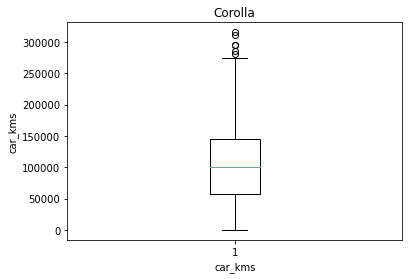

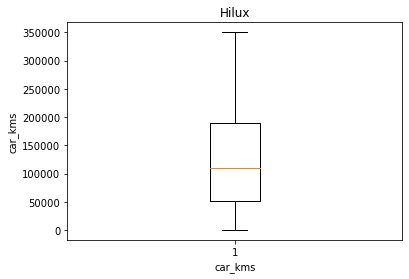

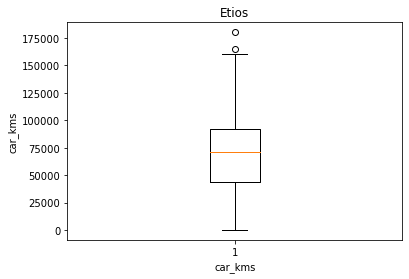

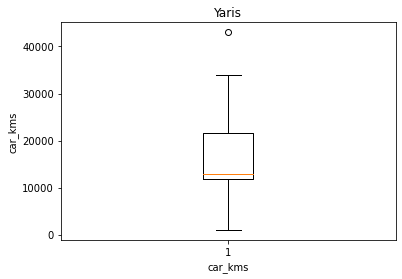

In [120]:
for i in modelos:
    sub_mask = data.match_modelo_a == i
    plt.boxplot(data[sub_mask]['car_kms'])
    plt.xlabel('car_kms')
    plt.ylabel('car_kms')
    plt.title(i)
    plt.show()

In [121]:
mask = df_train.match_modelo_a == 'Etios'
data = df_train[mask].copy()
q1 = data.car_kms.quantile(0.25)
q3 = data.car_kms.quantile(0.75)
IQR = q3 - q1
outl_thresh_superior = q3+1.5*IQR
print(outl_thresh_superior)
print(len(data[data.car_kms>=outl_thresh_superior]))

164000.0
2


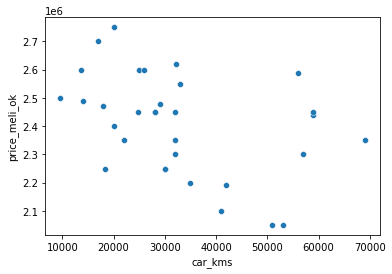

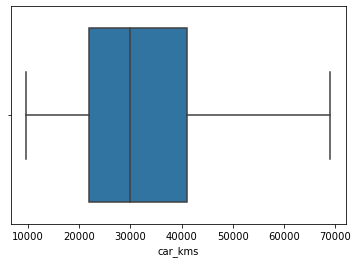

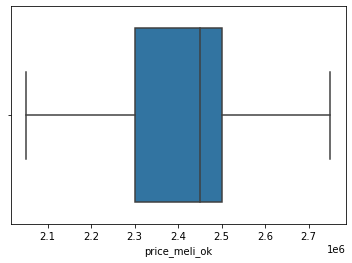

In [122]:
mask1 =df_train.match_marca_a == 'VOLKSWAGEN'
mask2 =df_train.match_modelo_a == 'Gol Trend'
mask3 =df_train.car_year == 2019
#mask3 =df_train.match_v1_a == '1.6 3Ptas. Trendline / Pack I (101cv) '

sns.scatterplot(df_train[mask1 & mask2 & mask3]['car_kms'],df_train[mask1 & mask2 & mask3]['price_meli_ok']);
plt.show()
sns.boxplot(df_train[mask1 & mask2 & mask3]['car_kms'])
plt.show()
sns.boxplot(df_train[mask1 & mask2 & mask3]['price_meli_ok'],)
plt.show()
#df_train[mask1 & mask2 & mask3].groupby('car_year')['price_meli_ok'].mean().plot.bar()
#plt.show()

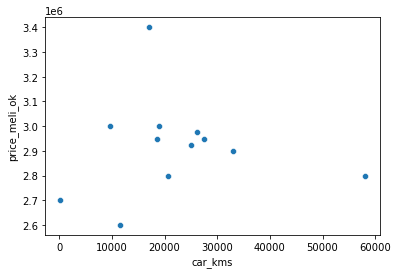

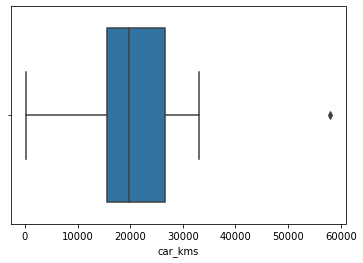

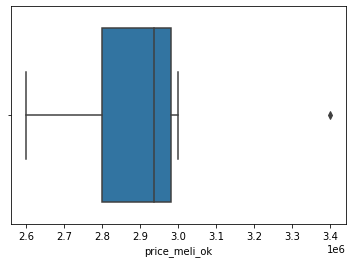

In [123]:
mask1 =df_train.match_marca_a == 'TOYOTA'
mask2 =df_train.match_modelo_a == 'Etios'
mask3 =df_train.car_year == 2019
#mask3 =df_train.match_v1_a == '1.6 3Ptas. Trendline / Pack I (101cv) '

sns.scatterplot(df_train[mask1 & mask2 & mask3]['car_kms'],df_train[mask1 & mask2 & mask3]['price_meli_ok']);
plt.show()
sns.boxplot(df_train[mask1 & mask2 & mask3]['car_kms'])
plt.show()
sns.boxplot(df_train[mask1 & mask2 & mask3]['price_meli_ok'],)
plt.show()
#df_train[mask1 & mask2 & mask3].groupby('car_year')['price_meli_ok'].mean().plot.bar()
#plt.show()

In [124]:
mask1 = df_train.match_modelo_a == 'Etios'
mask2 = df_train.car_year == 2019
data = df_train[mask1 & mask2].copy()
q1 = data.car_kms.quantile(0.25)
q3 = data.car_kms.quantile(0.75)
IQR = q3 - q1
outl_thresh_superior = q3+1.5*IQR
print(outl_thresh_superior)
print(len(data[data.car_kms>=outl_thresh_superior]))

42875.0
1


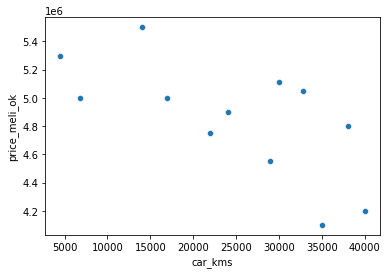

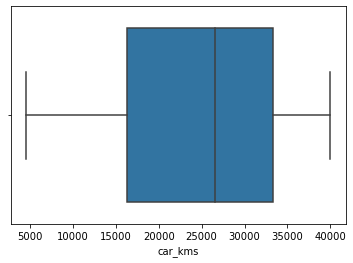

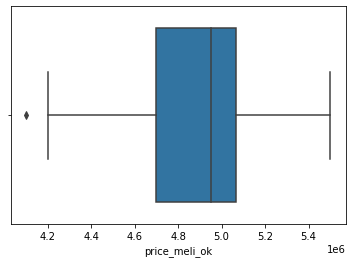

In [125]:
mask1 =df_train.match_marca_a == 'VOLKSWAGEN'
mask2 =df_train.match_modelo_a == 'T-Cross'
#mask3 =df_train.car_year == 2019
#mask3 =df_train.match_v1_a == '1.6 3Ptas. Trendline / Pack I (101cv) '

sns.scatterplot(df_train[mask1 & mask2]['car_kms'],df_train[mask1 & mask2]['price_meli_ok']);
plt.show()
sns.boxplot(df_train[mask1 & mask2]['car_kms'])
plt.show()
sns.boxplot(df_train[mask1 & mask2]['price_meli_ok'],)
plt.show()

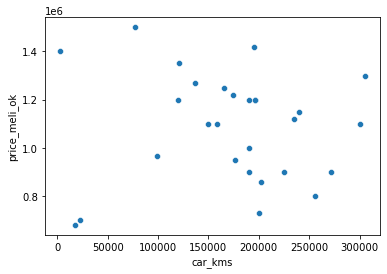

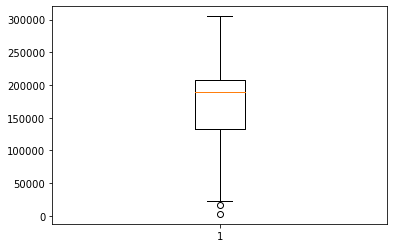

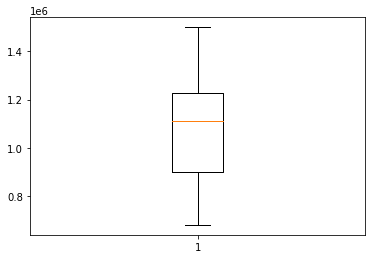

In [126]:
mask1 =df_train.match_marca_a == 'RENAULT'
mask2 =df_train.match_modelo_a == 'Kangoo'
mask3 =df_train.car_year == 2009
#mask3 =df_train.match_v1_a == '1.6 3Ptas. Trendline / Pack I (101cv) '

sns.scatterplot(df_train[mask1 & mask2 & mask3]['car_kms'],df_train[mask1 & mask2 & mask3]['price_meli_ok']);
plt.show()
plt.boxplot(df_train[mask1 & mask2 & mask3]['car_kms'])
plt.show()
plt.boxplot(df_train[mask1 & mask2 & mask3]['price_meli_ok'],)
plt.show()

Aca podemos chequear el valor extremo de la Kangoo que hace que haya aparecido cuando nos fijamos los registros que quedaban por encima del p99 luego de haber hecho el tratamiento de outliers nº1.

También es interesante observar en el boxplot de kms como sale un outlier inferior: es imposible (o demasiado raro) que una kangoo del 2009 tenga menos de 10.000 kms. Todos estos casos ilogicos los vamos a estar eliminando en esta seccion "Tratamiento de outliers nº2"

In [127]:
mask1 = df_train.match_modelo_a == 'Kangoo'
mask2 = df_train.car_year == 2009
data = df_train[mask1 & mask2].copy()
q1 = data.price_meli_ok.quantile(0.25)
q3 = data.price_meli_ok.quantile(0.75)
IQR = q3 - q1
outl_thresh_superior = q3+1.5*IQR
print(outl_thresh_superior)
print(len(data[data.price_meli_ok>outl_thresh_superior]))

1718750.0
0


In [128]:
mask1 = df_train.match_modelo_a == 'Kangoo'
mask2 = df_train.car_year == 2009
data = df_train[mask1 & mask2].copy()
q1 = data.price_meli_ok.quantile(0.25)
q3 = data.price_meli_ok.quantile(0.75)
IQR = q3 - q1
outl_thresh_inferior = q1-1.5*IQR
print(outl_thresh_inferior)
print(len(data[data.price_meli_ok<outl_thresh_inferior]))

408750.0
0


---

### *Tratamiento de outliers nº2*
* Es un tratamiento profundo donde buscamos **outliers por contexto** (outliers a nivel de agg marca-modelo-año)
* Notar que se hace despues del Split sobre el train, para evitar data leakage! Es decir: fit_transform sobre train y transform sobre test
* Luego lo aplicaremos sobre test pero con los thresholds de outliers aprendidos en train.

In [129]:
df_train['car_year'].dtype

dtype('int64')

In [130]:
# Dropeamos todos los outliers por contexo: "Tratamiento de outliers nº2"

modelos = sorted(list(df_train.match_modelo_a.unique()))
años = sorted(list(df_train.car_year.unique()))
kms_thresh_outliers = {}
price_thresh_outliers = {}
old_shape = df_train.shape[0]
for m in modelos:
    for a in años:
        # print(f'{m} of {a}') --> solo para chequear que el loop este iterando correctamente (esta OK :)
        
        modelo_año = m + '_' + str(a)
        
        
        # kms
        mask1 = df_train.match_modelo_a == m
        mask2 = df_train.car_year == a
        data = df_train[mask1 & mask2].copy()
        
        q1 = data.car_kms.quantile(0.25)
        q3 = data.car_kms.quantile(0.75)
        IQR = q3 - q1
        outl_thresh_superior = q3+3*IQR
        outl_thresh_inferior = q1-3*IQR
        kms_thresh_outliers[modelo_año] = (outl_thresh_inferior,outl_thresh_superior)
        filt_mask_sup = data.car_kms>kms_thresh_outliers[modelo_año][1]
        filt_mask_inf = data.car_kms<kms_thresh_outliers[modelo_año][0]
        data = data[~(filt_mask_sup | filt_mask_inf)]
        df_train = df_train.loc[~(mask1 & mask2),:]
        df_train = pd.concat([df_train,data],0)
        
        # price
        mask1 = df_train.match_modelo_a == m
        mask2 = df_train.car_year == a
        data = df_train[mask1 & mask2].copy()
        
        q1 = data.price_meli_ok.quantile(0.25)
        q3 = data.price_meli_ok.quantile(0.75)
        IQR = q3 - q1
        outl_thresh_superior = q3+3*IQR
        outl_thresh_inferior = q1-3*IQR
        price_thresh_outliers[modelo_año] = (outl_thresh_inferior,outl_thresh_superior)
        filt_mask_sup = data.price_meli_ok>price_thresh_outliers[modelo_año][1]
        filt_mask_inf = data.price_meli_ok<price_thresh_outliers[modelo_año][0]
        data = data[~(filt_mask_sup | filt_mask_inf)]
        df_train = df_train.loc[~(mask1 & mask2),:]
        df_train = pd.concat([df_train,data],0)

print(f'Hey! {old_shape - df_train.shape[0]} were removed from df_train due to outliers under context')        

Hey! 249 were removed from df_train due to outliers under context


In [131]:
kms_thresh_outliers

{'2008_2006': (nan, nan),
 '2008_2007': (nan, nan),
 '2008_2008': (nan, nan),
 '2008_2009': (nan, nan),
 '2008_2010': (nan, nan),
 '2008_2011': (nan, nan),
 '2008_2012': (nan, nan),
 '2008_2013': (nan, nan),
 '2008_2014': (nan, nan),
 '2008_2015': (nan, nan),
 '2008_2016': (-8000.0, 139000.0),
 '2008_2017': (-54100.0, 179175.0),
 '2008_2018': (-58750.0, 147750.0),
 '2008_2019': (-3125.0, 61625.0),
 '2008_2020': (-39242.0, 70119.0),
 '2008_2021': (-21625.0, 41375.0),
 '206_2006': (-64200.0, 392900.0),
 '206_2007': (8000.0, 323000.0),
 '206_2008': (-5000.0, 329250.0),
 '206_2009': (-60500.0, 338500.0),
 '206_2010': (-63500.0, 339000.0),
 '206_2011': (-147050.0, 471225.0),
 '206_2012': (21500.0, 199125.0),
 '206_2013': (nan, nan),
 '206_2014': (nan, nan),
 '206_2015': (nan, nan),
 '206_2016': (nan, nan),
 '206_2017': (nan, nan),
 '206_2018': (nan, nan),
 '206_2019': (nan, nan),
 '206_2020': (nan, nan),
 '206_2021': (nan, nan),
 '207_2006': (nan, nan),
 '207_2007': (nan, nan),
 '207_2008':

**Chequeos**

In [132]:
df_train.shape

(25140, 10)

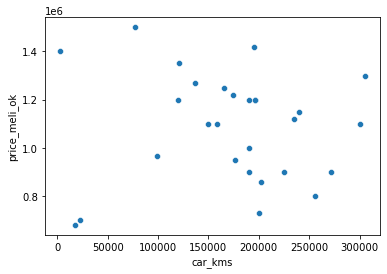

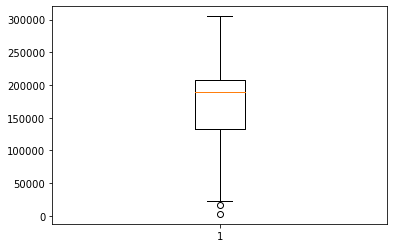

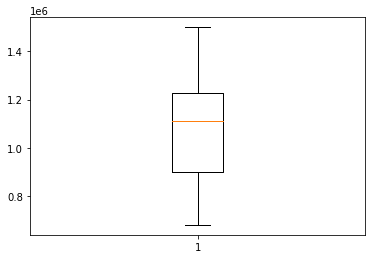

In [133]:
mask1 =df_train.match_marca_a == 'RENAULT'
mask2 =df_train.match_modelo_a == 'Kangoo'
mask3 =df_train.car_year == 2009

sns.scatterplot(df_train[mask1 & mask2 & mask3]['car_kms'],df_train[mask1 & mask2 & mask3]['price_meli_ok']);
plt.show()
plt.boxplot(df_train[mask1 & mask2 & mask3]['car_kms'])
plt.show()
plt.boxplot(df_train[mask1 & mask2 & mask3]['price_meli_ok'],)
plt.show()

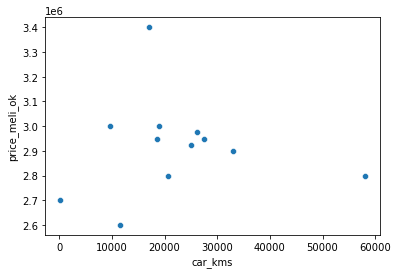

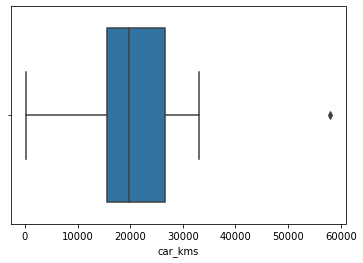

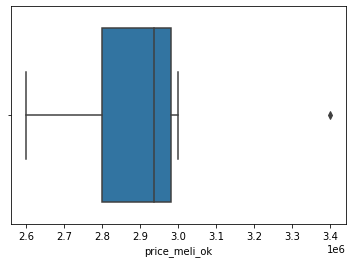

In [134]:
mask1 =df_train.match_marca_a == 'TOYOTA'
mask2 =df_train.match_modelo_a == 'Etios'
mask3 =df_train.car_year == 2019
#mask3 =df_train.match_v1_a == '1.6 3Ptas. Trendline / Pack I (101cv) '

sns.scatterplot(df_train[mask1 & mask2 & mask3]['car_kms'],df_train[mask1 & mask2 & mask3]['price_meli_ok']);
plt.show()
sns.boxplot(df_train[mask1 & mask2 & mask3]['car_kms'])
plt.show()
sns.boxplot(df_train[mask1 & mask2 & mask3]['price_meli_ok'],)
plt.show()

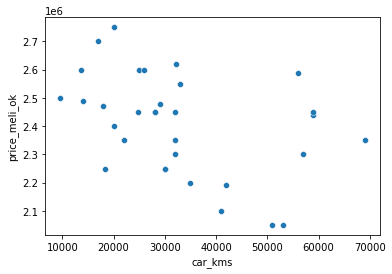

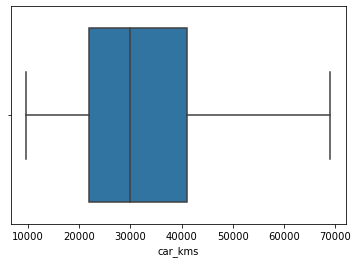

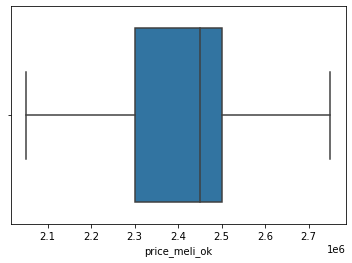

In [135]:
mask1 =df_train.match_marca_a == 'VOLKSWAGEN'
mask2 =df_train.match_modelo_a == 'Gol Trend'
mask3 =df_train.car_year == 2019
#mask3 =df_train.match_v1_a == '1.6 3Ptas. Trendline / Pack I (101cv) '

sns.scatterplot(df_train[mask1 & mask2 & mask3]['car_kms'],df_train[mask1 & mask2 & mask3]['price_meli_ok']);
plt.show()
sns.boxplot(df_train[mask1 & mask2 & mask3]['car_kms'])
plt.show()
sns.boxplot(df_train[mask1 & mask2 & mask3]['price_meli_ok'],)
plt.show()

In [136]:
mask1 = df_train.match_modelo_a == 'Gol Trend'
mask2 = df_train.car_year == 2019
data = df_train[mask1 & mask2].copy()
q1 = data.price_meli_ok.quantile(0.25)
q3 = data.price_meli_ok.quantile(0.75)
IQR = q3 - q1
outl_thresh_superior = q3+1.5*IQR
print(outl_thresh_superior)
print(len(data[data.price_meli_ok>outl_thresh_superior]))

2800000.0
0


Si bien es cierto que siguen apareciendo outliers, esto es normal debido a que con el tratamiento que hicimos la distribucion cambia y es logico que ahora un valor que antes no se consideraba outliers si se considere. Lo bueno es que ahora estos outliers ya no son tan extremos e irriorios.

In [137]:
price_thresh_outliers

{'2008_2006': (nan, nan),
 '2008_2007': (nan, nan),
 '2008_2008': (nan, nan),
 '2008_2009': (nan, nan),
 '2008_2010': (nan, nan),
 '2008_2011': (nan, nan),
 '2008_2012': (nan, nan),
 '2008_2013': (nan, nan),
 '2008_2014': (nan, nan),
 '2008_2015': (nan, nan),
 '2008_2016': (1650000.0, 3750000.0),
 '2008_2017': (1560000.0, 4255000.0),
 '2008_2018': (1265000.0, 5080000.0),
 '2008_2019': (1980000.0, 5165000.0),
 '2008_2020': (465000.0, 7605000.0),
 '2008_2021': (1830000.0, 6240000.0),
 '206_2006': (500000.0, 1200000.0),
 '206_2007': (380000.0, 1290000.0),
 '206_2008': (350000.0, 1400000.0),
 '206_2009': (437500.0, 1312500.0),
 '206_2010': (100000.0, 1850000.0),
 '206_2011': (115000.0, 1935000.0),
 '206_2012': (480000.0, 1661250.0),
 '206_2013': (nan, nan),
 '206_2014': (nan, nan),
 '206_2015': (nan, nan),
 '206_2016': (nan, nan),
 '206_2017': (nan, nan),
 '206_2018': (nan, nan),
 '206_2019': (nan, nan),
 '206_2020': (nan, nan),
 '206_2021': (nan, nan),
 '207_2006': (nan, nan),
 '207_2007'

In [138]:
# Guardamos los diccionarios con la info de outiers thresholds en formato json
with open('{}kms_thresh_outliers.json'.format(path_save), 'w') as outfile:
    json.dump(kms_thresh_outliers, outfile)

with open('{}price_thresh_outliers.json'.format(path_save), 'w') as outfile:
    json.dump(price_thresh_outliers, outfile)

Notesé que en muchos casos nos quedan "nan", eso es porque aveces no tenemos ningun registro de un marca-modelo para un cierto año en particular (ej: talvez no se fabrico ese modelo durante ese año o cosas así). Por lo único que tendremos que tener cuidado es cuando apliquemos este cleaning sobre test, vamos a tener que poner un "if" que haga un "pass" en caso de que los thresh seas "nan"

In [139]:
df_train.to_csv('{}df_train_checkpoint_4.pkl'.format(path_save)) # este es el df_train final!
# el test sigue igual

# Applying data cleaning in the test set

In [140]:
df_train_ok = pd.read_csv('{}df_train_checkpoint_4.pkl'.format(path_save))

In [141]:
df_test = pd.read_csv('{}df_test_checkpoint_3.pkl'.format(path_save))

In [142]:
print(df_train_ok.shape)
print(df_test.shape)

(25140, 11)
(6410, 11)


In [143]:
# Aplicamos el data cleaning aprendido en train sobre el set de test para usarlo en la evaluacion
df_test_ok = cleaning_after_split(df_test,path_save)

Hey! 50 were removed due to outliers globales
Hey! 179 were removed from df due to outliers under context


In [144]:
df_test_ok.shape

(6181, 11)

In [145]:
df_test_ok.to_csv('{}df_test_checkpoint_4.pkl'.format(path_save)) # este es el df_test final!

In [146]:
df_test_ok = pd.read_csv('{}df_test_checkpoint_4.pkl'.format(path_save))
df_test_ok.shape

(6181, 12)

### Save the IDs that we've used in train

In [147]:
display(df_train_ok.car_id.nunique()
        ,df_test_ok.car_id.nunique())

25140

6181

In [148]:
# We can see that they are completely different
display(len(list(set(df_train_ok.car_id.unique()).difference(set(df_test_ok.car_id.unique()))))
        ,len(list(set(df_test_ok.car_id.unique()).difference(set(df_train_ok.car_id.unique()))))
       )

25140

6181

In [149]:
ids_dev = list(df_train_ok.car_id.unique()) + list(df_test_ok.car_id.unique())
len(ids_dev)

31321

In [150]:
len(set(ids_dev))

31321

In [151]:
df_ids_dev = pd.DataFrame(ids_dev, columns=['car_id_dev'])
df_ids_dev.to_csv('{}df_ids_dev.pkl'.format(path_save))

# Modelling

In [152]:
model_features = ['car_year','car_kms','match_marca_a','match_modelo_a','match_v1_a','Subseg_a', 'Seg_a']

In [153]:
# Volvemos a separar en X e y
X_train = df_train_ok[model_features]
y_train = df_train_ok.price_meli_ok

X_test = df_test_ok[model_features]
y_test = df_test_ok.price_meli_ok

## Modelo Baseline

In [154]:
X_train.columns

Index(['car_year', 'car_kms', 'match_marca_a', 'match_modelo_a', 'match_v1_a',
       'Subseg_a', 'Seg_a'],
      dtype='object')

In [155]:
# Recordar agregar esto en la funcion de procesamiento para la simulacion

# Cuando hice el tratamiento de 1111 y 99999 había pasado la feature de kms a int. Volvemos a pasar a float por el catboost
X_train['car_kms'] = X_train['car_kms'].astype('float')
X_test['car_kms'] = X_test['car_kms'].astype('float')

# probamos tanto usando year como int y como float y la perfo del modelo dio apenas mejor con year en float
X_train['car_year'] = X_train['car_year'].astype('float')
X_test['car_year'] = X_test['car_year'].astype('float')

In [156]:
X_train.dtypes

car_year          float64
car_kms           float64
match_marca_a      object
match_modelo_a     object
match_v1_a         object
Subseg_a           object
Seg_a              object
dtype: object

In [157]:
np.where(X_train[model_features].dtypes != np.float)[0]

array([2, 3, 4, 5, 6])

In [158]:
# model=CatBoostRegressor(loss_function='RMSE',logging_level="Silent")
# categorical_features_indices = np.where(X_train[model_features].dtypes != np.float)[0]
# model.fit(X_train, y_train, cat_features=categorical_features_indices)#, eval_set=(X_test, y_test))

# train_pred = model.predict(X_train)
# test_pred = model.predict(X_test)

# print('Train set evaluation:\n_____________________________________')
# print_evaluate(y_train, train_pred)
# print('Test set evaluation:\n_____________________________________')
# print_evaluate(y_test, test_pred)

In [159]:
# model.get_feature_importance(prettified=True)

In [160]:
model=CatBoostRegressor(loss_function='RMSE',logging_level="Silent")
categorical_features_indices = np.where(X_train[model_features].dtypes != np.float)[0]
model.fit(X_train, y_train, cat_features=categorical_features_indices)#, eval_set=(X_test, y_test))

train_pred = model.predict(X_train)
test_pred = model.predict(X_test)

print('Train set evaluation:\n_____________________________________')
print_evaluate(y_train, train_pred)
print('Test set evaluation:\n_____________________________________')
print_evaluate(y_test, test_pred)

Train set evaluation:
_____________________________________
MAE: 174729.27912860707
MAPE: 8.301614230685665
MEDAPE: 6.2626462464680515
MSE: 64372340505.19254
RMSE: 253717.04811697724
R2 Square 0.9666265739682877
__________________________________
Test set evaluation:
_____________________________________
MAE: 182938.5411836866
MAPE: 8.442411395125358
MEDAPE: 6.399963353940441
MSE: 74403473287.0973
RMSE: 272770.0007095672
R2 Square 0.961542402241049
__________________________________


In [161]:
model.get_feature_importance(prettified=True)

,Feature Id,Importances
0,car_year,33.50
1,Subseg_a,23.46
2,match_marca_a,14.23
3,match_modelo_a,11.79
4,Seg_a,8.03
5,match_v1_a,5.34
6,car_kms,3.65


In [162]:
# Save del modelo fiteado

path_model_save = '../model/'

import pickle
with open('{}model_catboost_v4.pickle'.format(path_model_save), 'wb') as f:
    pickle.dump(model, f)

---

### Model assesment (on test set)

In [163]:
test_pred = pd.Series(test_pred,name='test_pred')
d = pd.concat([X_test, y_test, test_pred],1)

In [164]:
d.head()

,car_year,car_kms,match_marca_a,match_modelo_a,match_v1_a,Subseg_a,Seg_a,price_meli_ok,test_pred
0,2021.00,1000.00,CITROEN,C3,1.6 VTi 115 Live (L16),Gama Pequenos Hatchback,Gama Pequenos,3200000,3301115.54
1,2020.00,32000.00,NISSAN,Sentra,SR 2.0 CVT (147cv) (L20),Gama Medianos Sedan,Gama Medianos,6200000,4767062.27
2,2020.00,21000.00,PEUGEOT,408,Feline 1.6 HDi MT (115cv) 4Ptas.,Gama Pequenos Sedan,Gama Pequenos,3500000,3483166.31
3,2020.00,18000.00,NISSAN,Sentra,SR 2.0 CVT (147cv) (L20),Gama Medianos Sedan,Gama Medianos,5900000,4826839.83
4,2011.00,103000.00,CHERY,Face,1.3 N Luxury 16v (83cv) 5Ptas.,Gama Pequenos Hatchback,Gama Pequenos,850000,1027390.18


In [165]:
y_test = d['price_meli_ok']
deciles_y_true = y_test.quantile([0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1])

dic = {}
for i in range(1,10+1):
    dic['d{}'.format(i)] = deciles_y_true.values[i-1]

In [166]:
dic

{'d1': 980000.0,
 'd2': 1280000.0,
 'd3': 1500000.0,
 'd4': 1750000.0,
 'd5': 1950000.0,
 'd6': 2299999.0,
 'd7': 2650000.0,
 'd8': 3250000.0,
 'd9': 4150000.0,
 'd10': 9000000.0}

In [167]:
# We discretize the vector of true labels to see it in deciles
d['y_true_disc'] = np.where(y_test <= dic['d1'], 'd01',
                       np.where((y_test > dic['d1']) & (y_test <= dic['d2']), 'd02',
                               np.where((y_test > dic['d2']) & (y_test <= dic['d3']), 'd03',
                                       np.where((y_test > dic['d3']) & (y_test <= dic['d4']), 'd04',
                                               np.where((y_test > dic['d4']) & (y_test <= dic['d5']), 'd05',
                                                       np.where((y_test > dic['d5']) & (y_test <= dic['d6']), 'd06',
                                                               np.where((y_test > dic['d6']) & (y_test <= dic['d7']), 'd07',
                                                                       np.where((y_test > dic['d7']) & (y_test <= dic['d8']), 'd08',
                                                                               np.where((y_test > dic['d8']) & (y_test <= dic['d9']), 'd09',
                                                                                       np.where((y_test > dic['d9']) & (y_test <= dic['d10']), 'd10','out_of_bounds'))))))))))

In [168]:
d.head(10)

,car_year,car_kms,match_marca_a,match_modelo_a,match_v1_a,Subseg_a,Seg_a,price_meli_ok,test_pred,y_true_disc
0,2021.00,1000.00,CITROEN,C3,1.6 VTi 115 Live (L16),Gama Pequenos Hatchback,Gama Pequenos,3200000,3301115.54,d08
1,2020.00,32000.00,NISSAN,Sentra,SR 2.0 CVT (147cv) (L20),Gama Medianos Sedan,Gama Medianos,6200000,4767062.27,d10
2,2020.00,21000.00,PEUGEOT,408,Feline 1.6 HDi MT (115cv) 4Ptas.,Gama Pequenos Sedan,Gama Pequenos,3500000,3483166.31,d09
3,2020.00,18000.00,NISSAN,Sentra,SR 2.0 CVT (147cv) (L20),Gama Medianos Sedan,Gama Medianos,5900000,4826839.83,d10
4,2011.00,103000.00,CHERY,Face,1.3 N Luxury 16v (83cv) 5Ptas.,Gama Pequenos Hatchback,Gama Pequenos,850000,1027390.18,d01
5,2013.00,136000.00,CHEVROLET,Aveo,LT 1.6 AT 4Ptas. (103cv),Gama Pequenos Sedan,Gama Pequenos,1400000,1245340.67,d03
6,2010.00,128292.00,AUDI,A4,1.8T FSI (170cv) MT Ambition,Gama Medianos Premium,Gama Medianos,2300000,2849355.51,d07
7,2017.00,94300.00,CHEVROLET,Cobalt,1.8 8v. LT MT (105cv),Gama Pequenos Sedan,Gama Pequenos,1800000,1966806.47,d05
8,2011.00,150000.00,SUZUKI,Swift,1.5 Nafta 5Ptas. (100cv),Gama Pequenos Hatchback,Gama Pequenos,1550000,1220728.56,d04
9,2019.00,60000.00,FIAT,Uno,Fire 1.3 Pack C / Way (68cv) 5Ptas.,Gama Pequenos Hatchback,Gama Pequenos,1300000,2017389.76,d03


In [169]:
# Accuracy
d['menos20perc'] = d.test_pred * 0.90
d['mas20perc'] = d.test_pred * 1.10
d['menos20perc'] = d['menos20perc'].astype('int')
d['mas20perc'] = d['mas20perc'].astype('int')
d['falls_in_range'] = np.where(
    (d['price_meli_ok']>=d['menos20perc']) & (d['price_meli_ok']<=d['mas20perc']),1,0)

In [170]:
d.head()

,car_year,car_kms,match_marca_a,match_modelo_a,match_v1_a,Subseg_a,Seg_a,price_meli_ok,test_pred,y_true_disc,menos20perc,mas20perc,falls_in_range
0,2021.00,1000.00,CITROEN,C3,1.6 VTi 115 Live (L16),Gama Pequenos Hatchback,Gama Pequenos,3200000,3301115.54,d08,2971003,3631227,1
1,2020.00,32000.00,NISSAN,Sentra,SR 2.0 CVT (147cv) (L20),Gama Medianos Sedan,Gama Medianos,6200000,4767062.27,d10,4290356,5243768,0
2,2020.00,21000.00,PEUGEOT,408,Feline 1.6 HDi MT (115cv) 4Ptas.,Gama Pequenos Sedan,Gama Pequenos,3500000,3483166.31,d09,3134849,3831482,1
3,2020.00,18000.00,NISSAN,Sentra,SR 2.0 CVT (147cv) (L20),Gama Medianos Sedan,Gama Medianos,5900000,4826839.83,d10,4344155,5309523,0
4,2011.00,103000.00,CHERY,Face,1.3 N Luxury 16v (83cv) 5Ptas.,Gama Pequenos Hatchback,Gama Pequenos,850000,1027390.18,d01,924651,1130129,0


In [171]:
# Overall Accuracy
d.falls_in_range.mean()

0.694709593916842

In [172]:
# Accuracy by decile
acc_by_dec = d.groupby('y_true_disc')['falls_in_range'].mean().reset_index()
acc_by_dec

,y_true_disc,falls_in_range
0,d01,0.52
1,d02,0.64
2,d03,0.68
3,d04,0.69
4,d05,0.74
5,d06,0.75
6,d07,0.73
7,d08,0.78
8,d09,0.74
9,d10,0.70


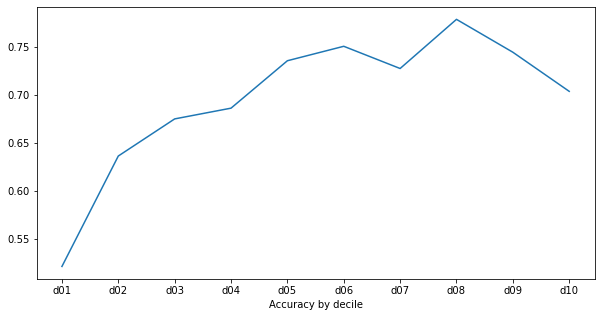

In [173]:
# plot distribution
fig = plt.figure(figsize = (10, 5))
plt.plot(acc_by_dec['y_true_disc'], acc_by_dec['falls_in_range'])
plt.xlabel("Accuracy by decile")
plt.show()

* Luego lo que podemos hacer es hacer aca mismo la validacion out of time arrancando de cero, sin mirar la nb de simulacion porque tal vez el error esta en ese codigo del output final

## Validacion OOT
fecha: 20 de abril

In [174]:
path_save

'../datos/'

In [175]:
!pwd

/Users/santiagolean/repos/cotizador_vf/notebooks_train


In [176]:
# checkpoint upload
df_scoreo_oot = pd.read_pickle('{}df_score_oot2022-04-20.pkl'.format(path_save))

In [177]:
# chequeo
print(len(df_scoreo_oot))
print(df_scoreo_oot.date.min(), df_scoreo_oot.date.max())

105549
2022-04-20 2022-04-20


In [178]:
# Creamos la feature marca_modelo_version ya que necesitamos tenerla en el df para las funciones de limpieza
df_scoreo_oot['marca_modelo_version'] = df_scoreo_oot['match_marca_a'] + str(' - ') +df_scoreo_oot['match_modelo_a'] + str(' - ') + df_scoreo_oot['match_v1_a']

In [179]:
# aplicamos la limpieza pre split
df_scoreo_oot = cleaning_before_split(df_scoreo_oot,ventana=15)

Hey! 0 were removed due to null values
Hey! 7393 were removed due to duplicate values
Hey! 745 were removed due those 11111 or 9999 strange values
Hey! 10611 were removed due prices in dollars
Hey! 50833 were removed due to 0km or concesioarias
Hey! 7152 were removed due to match scores under 80%
Hey! 0 were removed due to last 15d filter
Hey! 4439 were removed due to categories in which we are not interested in score


In [180]:
df_scoreo_oot.head()

,runtime,car_id,car_year,car_kms,match_marca_a,match_modelo_a,match_v1_a,marca_modelo_version,Subseg_a,Seg_a,price_meli_ok,car_location_1,match_v1_c
66873,2022-04-20 00:00:26,1132656952,2020,20000,FORD,Ranger,3.2 TDCi C/Doble 4x2 XLT 6MT (200cv) (L20),FORD - Ranger - 3.2 TDCi C/Doble 4x2 XLT 6MT (...,Pickups Medianas-Grandes,Livianos,6750000,La Pampa,XLT
66886,2022-04-20 00:00:26,1124674579,2020,4200,FORD,Ranger,3.2 TDCi C/Doble 4x2 XLT 6MT (200cv) (L20),FORD - Ranger - 3.2 TDCi C/Doble 4x2 XLT 6MT (...,Pickups Medianas-Grandes,Livianos,10500000,Córdoba,XLT
66896,2022-04-20 00:00:26,1130729333,2020,11000,FORD,Ranger,3.2 TDCi C/Doble 4x2 XLT 6MT (200cv) (L20),FORD - Ranger - 3.2 TDCi C/Doble 4x2 XLT 6MT (...,Pickups Medianas-Grandes,Livianos,6200000,Bs.As. G.B.A. Sur,XLT
66899,2022-04-20 00:00:26,1129323002,2020,58000,FORD,Ranger,3.2 TDCi C/Doble 4x2 XLT 6MT (200cv) (L20),FORD - Ranger - 3.2 TDCi C/Doble 4x2 XLT 6MT (...,Pickups Medianas-Grandes,Livianos,6000000,Bs.As. G.B.A. Sur,XLT
66697,2022-04-20 00:00:26,1128989351,2020,75000,FORD,Ranger,3.2 TDCi C/Doble 4x2 XLS 6MT (200cv) (L20),FORD - Ranger - 3.2 TDCi C/Doble 4x2 XLS 6MT (...,Pickups Medianas-Grandes,Livianos,5850000,Córdoba,XL 2.3 4X2


In [181]:
# aplicamos la limpieza post split
df_scoreo_oot = cleaning_after_split(df_scoreo_oot,path_save)

Hey! 257 were removed due to outliers globales
Hey! 374 were removed from df due to outliers under context


In [182]:
df_scoreo_oot.shape

(23745, 13)

In [183]:
X_oot = df_scoreo_oot[model_features].copy()
y_oot = df_scoreo_oot.price_meli_ok.copy()

In [184]:
# Assesment
oot_pred = model.predict(X_oot)

print('OOT set evaluation:\n_____________________________________')
print_evaluate(y_oot, oot_pred)

OOT set evaluation:
_____________________________________
MAE: 177526.08554274624
MAPE: 8.129656507102752
MEDAPE: 6.232419980093216
MSE: 67654057917.05004
RMSE: 260103.93675807762
R2 Square 0.9648876090211718
__________________________________


### Model assesment (on validation/oot set)

In [185]:
oot_pred = pd.Series(oot_pred,name='oot_pred')
d = pd.concat([X_oot.reset_index(drop=True), y_oot.reset_index(drop=True), oot_pred],1)

In [186]:
d.head()

,car_year,car_kms,match_marca_a,match_modelo_a,match_v1_a,Subseg_a,Seg_a,price_meli_ok,oot_pred
0,2021.00,6700,RENAULT,Sandero,II - 2.0 16v RS (145cv),Gama Pequenos Hatchback,Gama Pequenos,3600000,3175439.40
1,2007.00,145000,VOLKSWAGEN,CrossFox,1.6 Trendline 5Ptas. (MY14 ABG ABS),Gama Pequenos Hatchback,Gama Pequenos,1200000,1201050.86
2,2012.00,82000,NISSAN,Frontier,C/Doble 4x4 2.5 TD 5AT LE Attack (172cv) (L13),Pickups Medianas-Grandes,Livianos,4200000,3725973.82
3,2017.00,91000,FIAT,Dobló,1.4 8v. Active PLC,Baja PU - Furgones,Livianos,2320000,2302122.71
4,2019.00,117000,NISSAN,Sentra,SR 2.0 CVT (147cv) (L20),Gama Medianos Sedan,Gama Medianos,3500000,3782576.13


In [187]:
y_val = d['price_meli_ok']
deciles_y_true = y_val.quantile([0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1])

dic = {}
for i in range(1,10+1):
    dic['d{}'.format(i)] = deciles_y_true.values[i-1]

In [188]:
dic

{'d1': 990000.0,
 'd2': 1300000.0,
 'd3': 1500000.0,
 'd4': 1788000.0000000019,
 'd5': 2000000.0,
 'd6': 2320000.0,
 'd7': 2699000.0,
 'd8': 3250000.0,
 'd9': 4150000.0,
 'd10': 9100000.0}

In [189]:
# We discretize the vector of true labels to see it in deciles
d['y_true_disc'] = np.where(y_val <= dic['d1'], 'd01',
                       np.where((y_val > dic['d1']) & (y_val <= dic['d2']), 'd02',
                               np.where((y_val > dic['d2']) & (y_val <= dic['d3']), 'd03',
                                       np.where((y_val > dic['d3']) & (y_val <= dic['d4']), 'd04',
                                               np.where((y_val > dic['d4']) & (y_val <= dic['d5']), 'd05',
                                                       np.where((y_val > dic['d5']) & (y_val <= dic['d6']), 'd06',
                                                               np.where((y_val > dic['d6']) & (y_val <= dic['d7']), 'd07',
                                                                       np.where((y_val > dic['d7']) & (y_val <= dic['d8']), 'd08',
                                                                               np.where((y_val > dic['d8']) & (y_val <= dic['d9']), 'd09',
                                                                                       np.where((y_val > dic['d9']) & (y_val <= dic['d10']), 'd10','out_of_bounds'))))))))))

In [190]:
d.head(10)

,car_year,car_kms,match_marca_a,match_modelo_a,match_v1_a,Subseg_a,Seg_a,price_meli_ok,oot_pred,y_true_disc
0,2021.00,6700,RENAULT,Sandero,II - 2.0 16v RS (145cv),Gama Pequenos Hatchback,Gama Pequenos,3600000,3175439.40,d09
1,2007.00,145000,VOLKSWAGEN,CrossFox,1.6 Trendline 5Ptas. (MY14 ABG ABS),Gama Pequenos Hatchback,Gama Pequenos,1200000,1201050.86,d02
2,2012.00,82000,NISSAN,Frontier,C/Doble 4x4 2.5 TD 5AT LE Attack (172cv) (L13),Pickups Medianas-Grandes,Livianos,4200000,3725973.82,d10
3,2017.00,91000,FIAT,Dobló,1.4 8v. Active PLC,Baja PU - Furgones,Livianos,2320000,2302122.71,d06
4,2019.00,117000,NISSAN,Sentra,SR 2.0 CVT (147cv) (L20),Gama Medianos Sedan,Gama Medianos,3500000,3782576.13,d09
5,2019.00,41000,NISSAN,Sentra,SR 2.0 CVT (147cv) (L20),Gama Medianos Sedan,Gama Medianos,3400000,4194824.39,d09
6,2015.00,98500,PEUGEOT,508,1.6 T Feline Tiptronic (163cv) (L16) 4Ptas.,Gama Grandes Sedan,Gama Grandes,2850000,2889704.39,d08
7,2019.00,46000,CHERY,Tiggo 5,2.0 Luxury MT (138hp) (L18),SUV 4X2,SUV,4500000,3347642.57,d10
8,2019.00,50000,CHERY,Tiggo 5,2.0 Luxury MT (138hp) (L18),SUV 4X2,SUV,3200000,3325086.19,d08
9,2013.00,136000,CHEVROLET,Aveo,LT 1.6 AT 4Ptas. (103cv),Gama Pequenos Sedan,Gama Pequenos,1400000,1245340.67,d03


In [191]:
# Accuracy
d['menos10perc'] = d.oot_pred * 0.90
d['mas10perc'] = d.oot_pred * 1.10
d['menos10perc'] = d['menos10perc'].astype('int')
d['mas10perc'] = d['mas10perc'].astype('int')
d['falls_in_range'] = np.where(
    (d['price_meli_ok']>=d['menos10perc']) & (d['price_meli_ok']<=d['mas10perc']),1,0)

In [192]:
d.head()

,car_year,car_kms,match_marca_a,match_modelo_a,match_v1_a,Subseg_a,Seg_a,price_meli_ok,oot_pred,y_true_disc,menos10perc,mas10perc,falls_in_range
0,2021.00,6700,RENAULT,Sandero,II - 2.0 16v RS (145cv),Gama Pequenos Hatchback,Gama Pequenos,3600000,3175439.40,d09,2857895,3492983,0
1,2007.00,145000,VOLKSWAGEN,CrossFox,1.6 Trendline 5Ptas. (MY14 ABG ABS),Gama Pequenos Hatchback,Gama Pequenos,1200000,1201050.86,d02,1080945,1321155,1
2,2012.00,82000,NISSAN,Frontier,C/Doble 4x4 2.5 TD 5AT LE Attack (172cv) (L13),Pickups Medianas-Grandes,Livianos,4200000,3725973.82,d10,3353376,4098571,0
3,2017.00,91000,FIAT,Dobló,1.4 8v. Active PLC,Baja PU - Furgones,Livianos,2320000,2302122.71,d06,2071910,2532334,1
4,2019.00,117000,NISSAN,Sentra,SR 2.0 CVT (147cv) (L20),Gama Medianos Sedan,Gama Medianos,3500000,3782576.13,d09,3404318,4160833,1


In [193]:
# Overall Accuracy
d.falls_in_range.mean()

0.7009475679090335

In [194]:
# Accuracy by decile
acc_by_dec = d.groupby('y_true_disc')['falls_in_range'].mean().reset_index()
acc_by_dec

,y_true_disc,falls_in_range
0,d01,0.52
1,d02,0.64
2,d03,0.68
3,d04,0.67
4,d05,0.74
5,d06,0.77
6,d07,0.75
7,d08,0.77
8,d09,0.75
9,d10,0.73


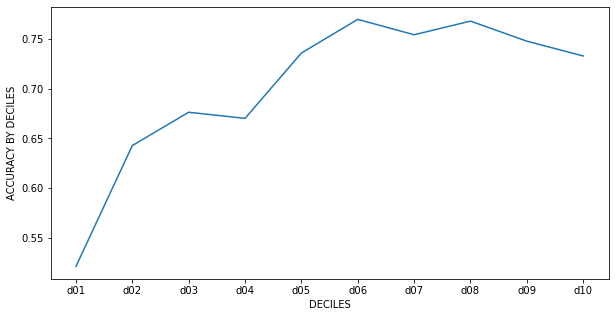

In [195]:
# plot distribution
fig = plt.figure(figsize = (10, 5))
plt.plot(acc_by_dec['y_true_disc'], acc_by_dec['falls_in_range'])
plt.xlabel("DECILES")
plt.ylabel("ACCURACY BY DECILES")
plt.show()

### Final Output

In [196]:
extra_features = ['car_id','match_v1_c','car_location_1']
data_output = pd.concat([df_scoreo_oot[extra_features].reset_index(drop=True)
                         ,X_oot.reset_index(drop=True)
                         ,pd.Series(y_oot,name='y_oot').reset_index(drop=True)
                         ,pd.Series(oot_pred,name='oot_pred')],1)
data_output

# faltaría sumarle una que indique el grupo de presencialidad (previo a eso re-entrenar sumando grupo 2 y 3 y ver como impacta en la perfo)

,car_id,match_v1_c,car_location_1,car_year,car_kms,match_marca_a,match_modelo_a,match_v1_a,Subseg_a,Seg_a,y_oot,oot_pred
0,1132553124,RS,Bs.As. G.B.A. Oeste,2021.00,6700,RENAULT,Sandero,II - 2.0 16v RS (145cv),Gama Pequenos Hatchback,Gama Pequenos,3600000,3175439.40
1,1132681065,1.6,Bs.As. G.B.A. Sur,2007.00,145000,VOLKSWAGEN,CrossFox,1.6 Trendline 5Ptas. (MY14 ABG ABS),Gama Pequenos Hatchback,Gama Pequenos,1200000,1201050.86
2,1130119880,4X4 SE 2.8TD(CAB.DOBLE),Bs.As. G.B.A. Oeste,2012.00,82000,NISSAN,Frontier,C/Doble 4x4 2.5 TD 5AT LE Attack (172cv) (L13),Pickups Medianas-Grandes,Livianos,4200000,3725973.82
3,1132721026,CARGO 1.4 16V ACTIVE,Bs.As. G.B.A. Oeste,2017.00,91000,FIAT,Dobló,1.4 8v. Active PLC,Baja PU - Furgones,Livianos,2320000,2302122.71
4,1132471156,2.0 SR CVT,Córdoba,2019.00,117000,NISSAN,Sentra,SR 2.0 CVT (147cv) (L20),Gama Medianos Sedan,Gama Medianos,3500000,3782576.13
...,...,...,...,...,...,...,...,...,...,...,...,...
23740,1127956829,GLS AUTOMATIC 2.0,Tucumán,2011.00,150000,CHEVROLET,Zafira,GLS 2.0 16v,Monovolumen Alto,Monovolumen,1500000,1397778.27
23741,1129828534,GLS AUTOMATIC 2.0,Córdoba,2011.00,215000,CHEVROLET,Zafira,GLS 2.0 16v,Monovolumen Alto,Monovolumen,1450000,1289191.72
23742,1131551630,GLS AUTOMATIC 2.0,Bs.As. G.B.A. Norte,2011.00,91200,CHEVROLET,Zafira,GLS 2.0 16v,Monovolumen Alto,Monovolumen,1710000,1529475.83
23743,1127723392,GLS AUTOMATIC 2.0,Bs.As. G.B.A. Norte,2011.00,140000,CHEVROLET,Zafira,GLS 2.0 16v,Monovolumen Alto,Monovolumen,1650000,1430215.99


In [197]:
# chequeo (tiene que mantenerse igual que el anterior) -- OK
print('OOT set evaluation:\n_____________________________________')
print_evaluate(data_output.y_oot, data_output.oot_pred)

OOT set evaluation:
_____________________________________
MAE: 177526.08554274624
MAPE: 8.129656507102752
MEDAPE: 6.232419980093216
MSE: 67654057917.05004
RMSE: 260103.93675807762
R2 Square 0.9648876090211718
__________________________________


---

In [198]:
# AGREGAR AL MODEL ASSESMENT UNA TABLA QUE QUEDE IDENTICA A LA QUE ME PASO DANI DEL EXAMEN DE LA CHICA PARA RAPPI (drive Kardur)

## Validacion OOT
fecha: 27 de abril

In [203]:
# Importar tabla de Big Query
#query = '''SELECT *
#           FROM `data-team-k.pricing_data.match_meli_ok`
#            WHERE date between "2022-04-22" and "2022-04-26"
#            '''
#df_scoreo_oot = gbq.read_gbq(query, project_id="data-team-k")

In [205]:
# checkpoint download
#df_scoreo_oot.to_csv('{}df_score_oot_mayor_2204.csv'.format(path_save))

In [204]:
# checkpoint upload
df_scoreo_oot = pd.read_csv('{}df_score_oot_mayor_2204.csv'.format(path_save))

In [206]:
df_scoreo_oot.shape

(557511, 43)

In [207]:
# chequeo
print(len(df_scoreo_oot))
print(df_scoreo_oot.date.min(), df_scoreo_oot.date.max())

557511
2022-04-22 2022-04-26


In [208]:
# Creamos la feature marca_modelo_version ya que necesitamos tenerla en el df para las funciones de limpieza
df_scoreo_oot['marca_modelo_version'] = df_scoreo_oot['match_marca_a'] + str(' - ') +df_scoreo_oot['match_modelo_a'] + str(' - ') + df_scoreo_oot['match_v1_a']

In [210]:
# aplicamos la limpieza pre split
df_scoreo_oot = cleaning_before_split(df_scoreo_oot,ventana=15)

Hey! 242 were removed due to null values
Hey! 443424 were removed due to duplicate values
Hey! 863 were removed due those 11111 or 9999 strange values
Hey! 12545 were removed due prices in dollars
Hey! 57663 were removed due to 0km or concesioarias
Hey! 8386 were removed due to match scores under 80%
Hey! 0 were removed due to last 15d filter
Hey! 5300 were removed due to categories in which we are not interested in score


In [211]:
df_scoreo_oot.shape

(29088, 13)

In [212]:
# aplicamos la limpieza post split
df_scoreo_oot = cleaning_after_split(df_scoreo_oot,path_save)

Hey! 281 were removed due to outliers globales
Hey! 510 were removed from df due to outliers under context


In [213]:
df_scoreo_oot.shape

(28297, 13)

In [214]:
model_features = ['car_year','car_kms','match_marca_a','match_modelo_a','match_v1_a','Subseg_a', 'Seg_a']

In [215]:
import pickle
path_model = '../model/'
with open('{}model_catboost_v4.pickle'.format(path_model), 'rb') as f:
    model = pickle.load(f)

In [216]:
X_oot = df_scoreo_oot[model_features].copy()
y_oot = df_scoreo_oot.price_meli_ok.copy()

In [217]:
# Assesment
oot_pred = model.predict(X_oot)

print('OOT set evaluation:\n_____________________________________')
print_evaluate(y_oot, oot_pred)

OOT set evaluation:
_____________________________________
MAE: 178307.19534218407
MAPE: 8.099762481237311
MEDAPE: 6.223243217143789
MSE: 68149067211.6476
RMSE: 261053.763067395
R2 Square 0.9648930677613266
__________________________________


### Model assesment (on validation/oot set)

In [218]:
oot_pred = pd.Series(oot_pred,name='oot_pred')
d = pd.concat([X_oot.reset_index(drop=True), y_oot.reset_index(drop=True), oot_pred],1)

In [219]:
d.head()

,car_year,car_kms,match_marca_a,match_modelo_a,match_v1_a,Subseg_a,Seg_a,price_meli_ok,oot_pred
0,2011.00,92000,CHERY,Face,1.3 N Luxury 16v (83cv) 5Ptas.,Gama Pequenos Hatchback,Gama Pequenos,730000,1023557.99
1,2011.00,103000,CHERY,Face,1.3 N Luxury 16v (83cv) 5Ptas.,Gama Pequenos Hatchback,Gama Pequenos,750000,1027390.18
2,2007.00,250000,HYUNDAI,Tucson,2.0 CRDI MT 4WD (L05),SUV 4X4,SUV,1700000,1786791.48
3,2021.00,6700,RENAULT,Sandero,II - 2.0 16v RS (145cv),Gama Pequenos Hatchback,Gama Pequenos,3600000,3175439.40
4,2006.00,104000,FORD,KA,1.0 Fly Viral (L/08),Gama Pequenos Hatchback,Gama Pequenos,780000,742049.17


In [220]:
y_val = d['price_meli_ok']
deciles_y_true = y_val.quantile([0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1])

dic = {}
for i in range(1,10+1):
    dic['d{}'.format(i)] = deciles_y_true.values[i-1]

In [221]:
dic

{'d1': 1000000.0,
 'd2': 1300000.0,
 'd3': 1520000.0,
 'd4': 1790000.0,
 'd5': 2000000.0,
 'd6': 2300000.0,
 'd7': 2700000.0,
 'd8': 3290000.0,
 'd9': 4200000.0,
 'd10': 9100000.0}

In [222]:
# We discretize the vector of true labels to see it in deciles
d['y_true_disc'] = np.where(y_val <= dic['d1'], 'd01',
                       np.where((y_val > dic['d1']) & (y_val <= dic['d2']), 'd02',
                               np.where((y_val > dic['d2']) & (y_val <= dic['d3']), 'd03',
                                       np.where((y_val > dic['d3']) & (y_val <= dic['d4']), 'd04',
                                               np.where((y_val > dic['d4']) & (y_val <= dic['d5']), 'd05',
                                                       np.where((y_val > dic['d5']) & (y_val <= dic['d6']), 'd06',
                                                               np.where((y_val > dic['d6']) & (y_val <= dic['d7']), 'd07',
                                                                       np.where((y_val > dic['d7']) & (y_val <= dic['d8']), 'd08',
                                                                               np.where((y_val > dic['d8']) & (y_val <= dic['d9']), 'd09',
                                                                                       np.where((y_val > dic['d9']) & (y_val <= dic['d10']), 'd10','out_of_bounds'))))))))))

In [223]:
d.head(10)

,car_year,car_kms,match_marca_a,match_modelo_a,match_v1_a,Subseg_a,Seg_a,price_meli_ok,oot_pred,y_true_disc
0,2011.00,92000,CHERY,Face,1.3 N Luxury 16v (83cv) 5Ptas.,Gama Pequenos Hatchback,Gama Pequenos,730000,1023557.99,d01
1,2011.00,103000,CHERY,Face,1.3 N Luxury 16v (83cv) 5Ptas.,Gama Pequenos Hatchback,Gama Pequenos,750000,1027390.18,d01
2,2007.00,250000,HYUNDAI,Tucson,2.0 CRDI MT 4WD (L05),SUV 4X4,SUV,1700000,1786791.48,d04
3,2021.00,6700,RENAULT,Sandero,II - 2.0 16v RS (145cv),Gama Pequenos Hatchback,Gama Pequenos,3600000,3175439.40,d09
4,2006.00,104000,FORD,KA,1.0 Fly Viral (L/08),Gama Pequenos Hatchback,Gama Pequenos,780000,742049.17,d01
5,2014.00,83000,AUDI,A4,1.8T FSI (170cv) MT Ambition,Gama Medianos Premium,Gama Medianos,4500000,3878017.21,d10
6,2006.00,158730,FIAT,Ducato,2.3 Mjet Maxicargo TE (L10),Furgon Mediano,Livianos,5750000,2494873.83,d10
7,2018.00,94000,CHEVROLET,Montana,1.8 8v. LS AA DA (105cv) DISCONTINUO,Baja PU - Furgones,Livianos,2100000,2173672.54,d06
8,2021.00,1000,CITROEN,C3,1.6 VTi 115 Live (L16),Gama Pequenos Hatchback,Gama Pequenos,3200000,3301115.54,d08
9,2021.00,8000,CITROEN,C3,1.6 VTi 115 Live (L16),Gama Pequenos Hatchback,Gama Pequenos,3100000,3209498.03,d08


In [224]:
# Accuracy
d['menos10perc'] = d.oot_pred * 0.9
d['mas10perc'] = d.oot_pred * 1.1
d['menos10perc'] = d['menos10perc'].astype('int')
d['mas10perc'] = d['mas10perc'].astype('int')
d['falls_in_range'] = np.where(
    (d['price_meli_ok']>=d['menos10perc']) & (d['price_meli_ok']<=d['mas10perc']),1,0)

In [225]:
d.head()

,car_year,car_kms,match_marca_a,match_modelo_a,match_v1_a,Subseg_a,Seg_a,price_meli_ok,oot_pred,y_true_disc,menos10perc,mas10perc,falls_in_range
0,2011.00,92000,CHERY,Face,1.3 N Luxury 16v (83cv) 5Ptas.,Gama Pequenos Hatchback,Gama Pequenos,730000,1023557.99,d01,921202,1125913,0
1,2011.00,103000,CHERY,Face,1.3 N Luxury 16v (83cv) 5Ptas.,Gama Pequenos Hatchback,Gama Pequenos,750000,1027390.18,d01,924651,1130129,0
2,2007.00,250000,HYUNDAI,Tucson,2.0 CRDI MT 4WD (L05),SUV 4X4,SUV,1700000,1786791.48,d04,1608112,1965470,1
3,2021.00,6700,RENAULT,Sandero,II - 2.0 16v RS (145cv),Gama Pequenos Hatchback,Gama Pequenos,3600000,3175439.40,d09,2857895,3492983,0
4,2006.00,104000,FORD,KA,1.0 Fly Viral (L/08),Gama Pequenos Hatchback,Gama Pequenos,780000,742049.17,d01,667844,816254,1


In [226]:
# Overall Accuracy
d.falls_in_range.mean()

0.6990493691910803

In [227]:
# Accuracy by decile
acc_by_dec = d.groupby('y_true_disc')['falls_in_range'].mean().reset_index()
acc_by_dec

,y_true_disc,falls_in_range
0,d01,0.52
1,d02,0.65
2,d03,0.68
3,d04,0.68
4,d05,0.74
5,d06,0.76
6,d07,0.74
7,d08,0.75
8,d09,0.74
9,d10,0.73


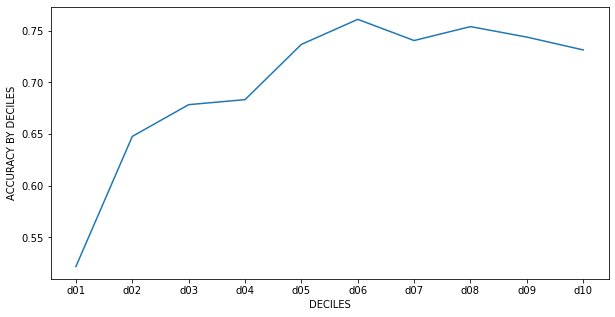

In [228]:
# plot distribution
fig = plt.figure(figsize = (10, 5))
plt.plot(acc_by_dec['y_true_disc'], acc_by_dec['falls_in_range'])
plt.xlabel("DECILES")
plt.ylabel("ACCURACY BY DECILES")
plt.show()

### Final Output

In [229]:
extra_features = ['car_id','match_v1_c','car_location_1']
data_output = pd.concat([df_scoreo_oot[extra_features].reset_index(drop=True)
                         ,X_oot.reset_index(drop=True)
                         ,pd.Series(y_oot,name='y_oot').reset_index(drop=True)
                         ,pd.Series(oot_pred,name='oot_pred')],1)
data_output

# faltaría sumarle una que indique el grupo de presencialidad (previo a eso re-entrenar sumando grupo 2 y 3 y ver como impacta en la perfo)

,car_id,match_v1_c,car_location_1,car_year,car_kms,match_marca_a,match_modelo_a,match_v1_a,Subseg_a,Seg_a,y_oot,oot_pred
0,1124533434,1.1,Chaco,2011.00,92000,CHERY,Face,1.3 N Luxury 16v (83cv) 5Ptas.,Gama Pequenos Hatchback,Gama Pequenos,730000,1023557.99
1,1132861682,1.1,Bs.As. G.B.A. Norte,2011.00,103000,CHERY,Face,1.3 N Luxury 16v (83cv) 5Ptas.,Gama Pequenos Hatchback,Gama Pequenos,750000,1027390.18
2,1124897344,2.0 4WD CRDI,Entre Ríos,2007.00,250000,HYUNDAI,Tucson,2.0 CRDI MT 4WD (L05),SUV 4X4,SUV,1700000,1786791.48
3,1132553124,RS,Bs.As. G.B.A. Oeste,2021.00,6700,RENAULT,Sandero,II - 2.0 16v RS (145cv),Gama Pequenos Hatchback,Gama Pequenos,3600000,3175439.40
4,1132121805,VIRAL,Bs.As. G.B.A. Norte,2006.00,104000,FORD,KA,1.0 Fly Viral (L/08),Gama Pequenos Hatchback,Gama Pequenos,780000,742049.17
...,...,...,...,...,...,...,...,...,...,...,...,...
28292,1127723392,GLS AUTOMATIC 2.0,Bs.As. G.B.A. Norte,2011.00,140000,CHEVROLET,Zafira,GLS 2.0 16v,Monovolumen Alto,Monovolumen,1650000,1430215.99
28293,1127956829,GLS AUTOMATIC 2.0,Tucumán,2011.00,150000,CHEVROLET,Zafira,GLS 2.0 16v,Monovolumen Alto,Monovolumen,1500000,1397778.27
28294,1131286221,GLS AUTOMATIC 2.0,Tierra del Fuego,2011.00,159000,CHEVROLET,Zafira,GLS 2.0 16v,Monovolumen Alto,Monovolumen,1500000,1389353.57
28295,1131495295,GLS AUTOMATIC 2.0,Santiago del Estero,2011.00,240000,CHEVROLET,Zafira,GLS 2.0 16v,Monovolumen Alto,Monovolumen,1500000,1274524.77


In [230]:
# chequeo (tiene que mantenerse igual que el anterior) -- OK
print('OOT set evaluation:\n_____________________________________')
print_evaluate(data_output.y_oot, data_output.oot_pred)

OOT set evaluation:
_____________________________________
MAE: 178307.19534218407
MAPE: 8.099762481237311
MEDAPE: 6.223243217143789
MSE: 68149067211.6476
RMSE: 261053.763067395
R2 Square 0.9648930677613266
__________________________________


---

## Validacion OOT (IDs nuevos!)
fecha de la corrida: 4 de mayo

In [232]:
# Importar tabla de Big Query
#query = '''SELECT *
#           FROM `data-team-k.pricing_data.match_meli_ok`
#           WHERE date > "2022-04-26"
#            '''
#df_scoreo_oot = gbq.read_gbq(query, project_id="data-team-k")

In [233]:
#df_scoreo_oot.shape

In [234]:
# checkpoint download
#df_scoreo_oot.to_csv('{}df_score_oot_IDsnuevos_mayor_2604.csv'.format(path_save))

In [235]:
# checkpoint upload
df_scoreo_oot = pd.read_csv('{}df_score_oot_IDsnuevos_mayor_2604.csv'.format(path_save))

In [236]:
df_scoreo_oot.shape

(861914, 43)

In [237]:
# chequeo
print(len(df_scoreo_oot))
print(df_scoreo_oot.date.min(), df_scoreo_oot.date.max())

861914
2022-04-26 2022-05-03


In [238]:
# Creamos la feature marca_modelo_version ya que necesitamos tenerla en el df para las funciones de limpieza
df_scoreo_oot['marca_modelo_version'] = df_scoreo_oot['match_marca_a'] + str(' - ') +df_scoreo_oot['match_modelo_a'] + str(' - ') + df_scoreo_oot['match_v1_a']

In [240]:
# aplicamos la limpieza pre split
df_scoreo_oot = cleaning_before_split(df_scoreo_oot,ventana=15)

Hey! 38 were removed due to null values
Hey! 741463 were removed due to duplicate values
Hey! 913 were removed due those 11111 or 9999 strange values
Hey! 13452 were removed due prices in dollars
Hey! 60664 were removed due to 0km or concesioarias
Hey! 14142 were removed due to match scores under 80%
Hey! 0 were removed due to last 15d filter
Hey! 6029 were removed due to categories in which we are not interested in score


In [241]:
df_scoreo_oot.shape

(25213, 13)

In [242]:
# aplicamos la limpieza post split
df_scoreo_oot = cleaning_after_split(df_scoreo_oot,path_save)

Hey! 203 were removed due to outliers globales
Hey! 504 were removed from df due to outliers under context


In [243]:
df_scoreo_oot.shape

(24506, 13)

In [244]:
# Eliminamos los car_id que ya hayamos usado para entrenar
ids_dev = list(df_ids_dev.car_id_dev.unique())
mask = df_scoreo_oot.car_id.apply(lambda x: x not in ids_dev)
df_scoreo_oot[mask].shape

(8006, 13)

In [245]:
model_features = ['car_year','car_kms','match_marca_a','match_modelo_a','match_v1_a','Subseg_a', 'Seg_a']

In [246]:
import pickle
path_model = '../model/'
with open('{}model_catboost_v4.pickle'.format(path_model), 'rb') as f:
    model = pickle.load(f)

In [247]:
X_oot = df_scoreo_oot[model_features].copy()
y_oot = df_scoreo_oot.price_meli_ok.copy()

In [248]:
# Assesment
oot_pred = model.predict(X_oot)

print('OOT set evaluation:\n_____________________________________')
print_evaluate(y_oot, oot_pred)

OOT set evaluation:
_____________________________________
MAE: 174415.83366085598
MAPE: 8.196241874917275
MEDAPE: 6.32551098590172
MSE: 64296839791.293884
RMSE: 253568.21526227196
R2 Square 0.9623827757971364
__________________________________


### Model assesment (on validation/oot set)

In [249]:
oot_pred = pd.Series(oot_pred,name='oot_pred')
d = pd.concat([X_oot.reset_index(drop=True), y_oot.reset_index(drop=True), oot_pred],1)

In [250]:
d.head()

,car_year,car_kms,match_marca_a,match_modelo_a,match_v1_a,Subseg_a,Seg_a,price_meli_ok,oot_pred
0,2006.00,158730,FIAT,Ducato,2.3 Mjet Maxicargo TE (L10),Furgon Mediano,Livianos,5750000,2494873.83
1,2019.00,6900,CITROEN,C4,5Ptas.- 1.6 Hdi SX,Gama Medianos Sedan,Gama Medianos,3950000,3348960.77
2,2019.00,60000,FIAT,Uno,Fire 1.3 Pack C / Way (68cv) 5Ptas.,Gama Pequenos Hatchback,Gama Pequenos,1350000,2017389.76
3,2007.00,138000,VOLKSWAGEN,CrossFox,1.6 Trendline 5Ptas. (MY14 ABG ABS),Gama Pequenos Hatchback,Gama Pequenos,1029000,1219899.21
4,2016.00,79900,RENAULT,Captur,2.0 16v 6MT Intens Bitono Nav. Evo. (143cv),Suv Compactas 4x2,SUV,3570000,3067449.81


In [251]:
y_val = d['price_meli_ok']
deciles_y_true = y_val.quantile([0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1])

dic = {}
for i in range(1,10+1):
    dic['d{}'.format(i)] = deciles_y_true.values[i-1]

In [252]:
dic

{'d1': 1000000.0,
 'd2': 1290000.0,
 'd3': 1500000.0,
 'd4': 1740000.0,
 'd5': 1950000.0,
 'd6': 2250000.0,
 'd7': 2600000.0,
 'd8': 3200000.0,
 'd9': 4000000.0,
 'd10': 9100000.0}

In [253]:
# We discretize the vector of true labels to see it in deciles
d['y_true_disc'] = np.where(y_val <= dic['d1'], 'd01',
                       np.where((y_val > dic['d1']) & (y_val <= dic['d2']), 'd02',
                               np.where((y_val > dic['d2']) & (y_val <= dic['d3']), 'd03',
                                       np.where((y_val > dic['d3']) & (y_val <= dic['d4']), 'd04',
                                               np.where((y_val > dic['d4']) & (y_val <= dic['d5']), 'd05',
                                                       np.where((y_val > dic['d5']) & (y_val <= dic['d6']), 'd06',
                                                               np.where((y_val > dic['d6']) & (y_val <= dic['d7']), 'd07',
                                                                       np.where((y_val > dic['d7']) & (y_val <= dic['d8']), 'd08',
                                                                               np.where((y_val > dic['d8']) & (y_val <= dic['d9']), 'd09',
                                                                                       np.where((y_val > dic['d9']) & (y_val <= dic['d10']), 'd10','out_of_bounds'))))))))))

In [254]:
d.head(10)

,car_year,car_kms,match_marca_a,match_modelo_a,match_v1_a,Subseg_a,Seg_a,price_meli_ok,oot_pred,y_true_disc
0,2006.00,158730,FIAT,Ducato,2.3 Mjet Maxicargo TE (L10),Furgon Mediano,Livianos,5750000,2494873.83,d10
1,2019.00,6900,CITROEN,C4,5Ptas.- 1.6 Hdi SX,Gama Medianos Sedan,Gama Medianos,3950000,3348960.77,d09
2,2019.00,60000,FIAT,Uno,Fire 1.3 Pack C / Way (68cv) 5Ptas.,Gama Pequenos Hatchback,Gama Pequenos,1350000,2017389.76,d03
3,2007.00,138000,VOLKSWAGEN,CrossFox,1.6 Trendline 5Ptas. (MY14 ABG ABS),Gama Pequenos Hatchback,Gama Pequenos,1029000,1219899.21,d02
4,2016.00,79900,RENAULT,Captur,2.0 16v 6MT Intens Bitono Nav. Evo. (143cv),Suv Compactas 4x2,SUV,3570000,3067449.81,d09
5,2013.00,126000,PEUGEOT,206,5Ptas. 1.4 Active / EdG Géneration,Gama Pequenos Hatchback,Gama Pequenos,1220000,1263402.07,d02
6,2008.00,200000,DODGE,Journey,SXT 2.4 3 Filas,SUV 4X4,SUV,2000000,1880595.21,d06
7,2017.00,91000,FIAT,Dobló,1.4 8v. Active PLC,Baja PU - Furgones,Livianos,2320000,2302122.71,d07
8,2021.00,6700,RENAULT,Sandero,II - 2.0 16v RS (145cv),Gama Pequenos Hatchback,Gama Pequenos,3600000,3175439.40,d09
9,2007.00,145000,VOLKSWAGEN,CrossFox,1.6 Trendline 5Ptas. (MY14 ABG ABS),Gama Pequenos Hatchback,Gama Pequenos,1200000,1201050.86,d02


In [255]:
# Accuracy
d['menos10perc'] = d.oot_pred * 0.9
d['mas10perc'] = d.oot_pred * 1.1
d['menos10perc'] = d['menos10perc'].astype('int')
d['mas10perc'] = d['mas10perc'].astype('int')
d['falls_in_range'] = np.where(
    (d['price_meli_ok']>=d['menos10perc']) & (d['price_meli_ok']<=d['mas10perc']),1,0)

In [256]:
d.head()

,car_year,car_kms,match_marca_a,match_modelo_a,match_v1_a,Subseg_a,Seg_a,price_meli_ok,oot_pred,y_true_disc,menos10perc,mas10perc,falls_in_range
0,2006.00,158730,FIAT,Ducato,2.3 Mjet Maxicargo TE (L10),Furgon Mediano,Livianos,5750000,2494873.83,d10,2245386,2744361,0
1,2019.00,6900,CITROEN,C4,5Ptas.- 1.6 Hdi SX,Gama Medianos Sedan,Gama Medianos,3950000,3348960.77,d09,3014064,3683856,0
2,2019.00,60000,FIAT,Uno,Fire 1.3 Pack C / Way (68cv) 5Ptas.,Gama Pequenos Hatchback,Gama Pequenos,1350000,2017389.76,d03,1815650,2219128,0
3,2007.00,138000,VOLKSWAGEN,CrossFox,1.6 Trendline 5Ptas. (MY14 ABG ABS),Gama Pequenos Hatchback,Gama Pequenos,1029000,1219899.21,d02,1097909,1341889,0
4,2016.00,79900,RENAULT,Captur,2.0 16v 6MT Intens Bitono Nav. Evo. (143cv),Suv Compactas 4x2,SUV,3570000,3067449.81,d09,2760704,3374194,0


In [257]:
# Overall Accuracy
d.falls_in_range.mean()

0.6939525014282216

In [258]:
# Accuracy by decile
acc_by_dec = d.groupby('y_true_disc')['falls_in_range'].mean().reset_index()
acc_by_dec

,y_true_disc,falls_in_range
0,d01,0.52
1,d02,0.65
2,d03,0.66
3,d04,0.68
4,d05,0.73
5,d06,0.76
6,d07,0.73
7,d08,0.76
8,d09,0.73
9,d10,0.74


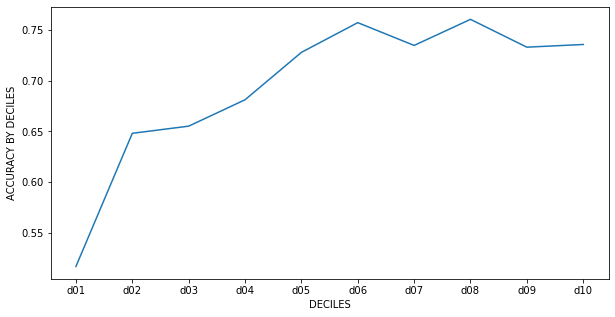

In [259]:
# plot distribution
fig = plt.figure(figsize = (10, 5))
plt.plot(acc_by_dec['y_true_disc'], acc_by_dec['falls_in_range'])
plt.xlabel("DECILES")
plt.ylabel("ACCURACY BY DECILES")
plt.show()

### Final Output

In [260]:
extra_features = ['car_id','match_v1_c','car_location_1']
data_output = pd.concat([df_scoreo_oot[extra_features].reset_index(drop=True)
                         ,X_oot.reset_index(drop=True)
                         ,pd.Series(y_oot,name='y_oot').reset_index(drop=True)
                         ,pd.Series(oot_pred,name='oot_pred')],1)
data_output

# faltaría sumarle una que indique el grupo de presencialidad (previo a eso re-entrenar sumando grupo 2 y 3 y ver como impacta en la perfo)

,car_id,match_v1_c,car_location_1,car_year,car_kms,match_marca_a,match_modelo_a,match_v1_a,Subseg_a,Seg_a,y_oot,oot_pred
0,1125057458,FURGON,Buenos Aires Interior,2006.00,158730,FIAT,Ducato,2.3 Mjet Maxicargo TE (L10),Furgon Mediano,Livianos,5750000,2494873.83
1,1131589938,LOUNGE THP 165 EAT6 SHINE AM19.5,Mendoza,2019.00,6900,CITROEN,C4,5Ptas.- 1.6 Hdi SX,Gama Medianos Sedan,Gama Medianos,3950000,3348960.77
2,1125369119,WAY 1.3 MPI 8V,Bs.As. G.B.A. Norte,2019.00,60000,FIAT,Uno,Fire 1.3 Pack C / Way (68cv) 5Ptas.,Gama Pequenos Hatchback,Gama Pequenos,1350000,2017389.76
3,1133334758,1.6,Bs.As. G.B.A. Norte,2007.00,138000,VOLKSWAGEN,CrossFox,1.6 Trendline 5Ptas. (MY14 ABG ABS),Gama Pequenos Hatchback,Gama Pequenos,1029000,1219899.21
4,1125544164,INTENS 2.0,Bs.As. G.B.A. Norte,2016.00,79900,RENAULT,Captur,2.0 16v 6MT Intens Bitono Nav. Evo. (143cv),Suv Compactas 4x2,SUV,3570000,3067449.81
...,...,...,...,...,...,...,...,...,...,...,...,...
24501,1131286221,"VAN 2,0 16V GLS II",Tierra del Fuego,2011.00,159000,CHEVROLET,Zafira,GLS 2.0 16v,Monovolumen Alto,Monovolumen,1500000,1389353.57
24502,1127956829,"VAN 2,0 16V GLS II",Tucumán,2011.00,150000,CHEVROLET,Zafira,GLS 2.0 16v,Monovolumen Alto,Monovolumen,1500000,1397778.27
24503,1127723392,"VAN 2,0 16V GLS II",Bs.As. G.B.A. Norte,2011.00,140000,CHEVROLET,Zafira,GLS 2.0 16v,Monovolumen Alto,Monovolumen,1650000,1430215.99
24504,1129828534,"VAN 2,0 16V GLS II",Córdoba,2011.00,215000,CHEVROLET,Zafira,GLS 2.0 16v,Monovolumen Alto,Monovolumen,1450000,1289191.72


In [261]:
# chequeo (tiene que mantenerse igual que el anterior) -- OK
print('OOT set evaluation:\n_____________________________________')
print_evaluate(data_output.y_oot, data_output.oot_pred)

OOT set evaluation:
_____________________________________
MAE: 174415.83366085598
MAPE: 8.196241874917275
MEDAPE: 6.32551098590172
MSE: 64296839791.293884
RMSE: 253568.21526227196
R2 Square 0.9623827757971364
__________________________________


In [265]:
# Worst MAPE
data_output['mape'] = (abs(data_output['y_oot'] - data_output['oot_pred']) / data_output.y_oot)

In [266]:
data_output.head()

,car_id,match_v1_c,car_location_1,car_year,car_kms,match_marca_a,match_modelo_a,match_v1_a,Subseg_a,Seg_a,y_oot,oot_pred,mape
0,1125057458,FURGON,Buenos Aires Interior,2006.00,158730,FIAT,Ducato,2.3 Mjet Maxicargo TE (L10),Furgon Mediano,Livianos,5750000,2494873.83,0.57
1,1131589938,LOUNGE THP 165 EAT6 SHINE AM19.5,Mendoza,2019.00,6900,CITROEN,C4,5Ptas.- 1.6 Hdi SX,Gama Medianos Sedan,Gama Medianos,3950000,3348960.77,0.15
2,1125369119,WAY 1.3 MPI 8V,Bs.As. G.B.A. Norte,2019.00,60000,FIAT,Uno,Fire 1.3 Pack C / Way (68cv) 5Ptas.,Gama Pequenos Hatchback,Gama Pequenos,1350000,2017389.76,0.49
3,1133334758,1.6,Bs.As. G.B.A. Norte,2007.00,138000,VOLKSWAGEN,CrossFox,1.6 Trendline 5Ptas. (MY14 ABG ABS),Gama Pequenos Hatchback,Gama Pequenos,1029000,1219899.21,0.19
4,1125544164,INTENS 2.0,Bs.As. G.B.A. Norte,2016.00,79900,RENAULT,Captur,2.0 16v 6MT Intens Bitono Nav. Evo. (143cv),Suv Compactas 4x2,SUV,3570000,3067449.81,0.14


In [273]:
# Worst mape
data_output.mape.describe(percentiles=[0.1,0.2,0.25,0.5,0.75,0.85,0.9,0.95,0.99, 0.999])

count   24506.00
mean        0.08
std         0.08
min         0.00
10%         0.01
20%         0.02
25%         0.03
50%         0.06
75%         0.11
85%         0.14
90%         0.17
95%         0.21
99%         0.37
99.9%       0.70
max         2.62
Name: mape, dtype: float64

---

FIN

NEXT STEPS (reu 4 de Mayo con Pato):

- Validad si sumando los grupos de baja presen en el train y desopues en la evaluacion usar solo los grupos de alta presen y ver si mantenemos la perfomance de la metricas. (manteniendo la moneda en pesos).
    Si la respuesta es que si mantenemos la perfo --> usamos esta misma metodologia para el modelo dolarizado aumentando la ventana y sin aumentar la ventana.
    
- Llevar todo a clases y metodos y que el output sea la prediccion de UN lead.
    parametrizacion del metodo "re-entrenamiento" : ventana de dias (modelo en dolares eso es lo que nos permite jugar con la ventana)
    
- Reu pato santi para montarlo en Flask

- Schedular el re-entrenamiento

### Anotaciones viejas pero quizas alguna sirve. Repasarlas y ver cuales rescatamos y cual borramos

VOLVER A CORRER LA NB DE TRAIN CON DATA NUEVA POR DOS MOTIVOS:
    1) POR LE VIENE BIEN AL ALGORTIMO PARA LA PREDICCION
    2) PORQUE SE CORRIGIO LO DEL AÑO 2008 Y HAY QUE SUMAR A LOS JSON QUE CONTIENEN LA INFO DE OUTLIERS POR CONTEXTO, LA INFO DE LOS 2008. PARA SALIR DEL PASO LE HICE UN "PARCHE" A FUNC_COTIZADOR.PY

* Revision del sheets: OK
    - ver si los autos que predecimos mal son siempre los mismos o aveces los predecimos bien.
    - revisar si en la simulacion estan metiendosé casos de versiones que no se usaron para train --> esto era así debido a que lo de los grupos lo había hecho a nivel marca-modelo, ahora le agregue el nivel de version y esto se tendría que coregir... esperemos a ver los resultados de las simul
* Ajustar procesamiento. OK
    * Hacer la limpieza de categorias a nivel marca-modelo-version, para excluir tanto del entrenamiento como de las simulaciones las versiones con bajo vol. (esto podría generar que la variable version pase a tener mayor importance) --> dicho y hecho, así fue.<br>
de la mano con esto, calcular que % de versiones estan quedando afuera en cada marca-modelo (o a nivel general, validarlo con Pato)
* Si no funciona lo del rango en base a kms hacerlo sobre el output directamente (usaremos un 10% dado que el MAPE es 9%)
* Accucary en base al rango.
* Ajustar procesamiento en la simulacion
* Hacer la matriz de confu que hice para airtm


* Backlog:
    * Hacer procsamiento de la version usando lo de (L11) que sería 2011, en ese caso fijarnos que eso coincida con el con car_year, y sino coincide eliminar el registro (ver el chat con Emi) y luego re-entrenar.
    * Re-entrenar con un nuevo make_data más actualizado y actualizando el tipo de cambio
    * Optimizar hiperparametros a ver si logramos mejorar el mape (hacerlo desde la nube rappi) -- si con grid search no mejoramos, probar optuna

Cotizador

- cambios en el entrenamiento para el v4

	- score matcheo >= 80  (POST SPLIT)
	- limpieza de categorías a nivel marca-modelo-version (POST SPLIT)
	- solo incluimos grupos 1, 2 y 3 para el algoritmo (PRE SPLIT)
	- usamos 3 en lugar de 1.5 para el tratamiento de outliers por contexto (POST SPLIT)

- faltaría sumar estas modificaciones en el processing en la simulacion

## Optimización de Hiperparametros

In [157]:
# # A)
# parameters = {'depth'         : [6,8,10],
#               'learning_rate' : [0.01, 0.05, 0.1, 0.15],
#               'iterations'    : [100, 120, 150, 200, 250],
#               'l2_leaf_reg': [0.2, 0.5, 1, 3]
#              }


# #model.fit(X_train, y_train, cat_features=categorical_features_indices)#, eval_set=(X_test, y_test))

# model=CatBoostRegressor(loss_function='RMSE',logging_level="Silent")
# grid = GridSearchCV(estimator=model, param_grid = parameters, cv = 5, n_jobs= -1, scoring='r2')
# categorical_features_indices = np.where(X_train[model_features].dtypes != np.float)[0]
# grid.fit(X_train, y_train, cat_features=categorical_features_indices)#, eval_set=(X_test, y_test))    

# # Results from Grid Search
# print("\n========================================================")
# print(" Results from Grid Search " )
# print("========================================================")    

# print("\n The best estimator across ALL searched params:\n",
#       grid.best_estimator_)

# print("\n The best score across ALL searched params:\n",
#       grid.best_score_)

# print("\n The best parameters across ALL searched params:\n",
#       grid.best_params_)

# print("\n ========================================================")

Mediante la optimizacion de hiperparametros con GridSearch no mejoramos la performance. Tener en cuenta que el baseline de Catboost se caracteriza por ser bastante optimo. De todas formas más adelante podríamos probar Optuna a modo de mejora.

Por lo tanto, nuestro mejor modelo lo obtenemos con el baseline de CatBoost.

## Validacion OOT

In [55]:
# pending

Mejoras:
* Sumar la feature de discontinuados (Favio)
* Features de InfoAutos (Cande se esta encargando de eso pero todavía no las tenemos)
* Mejor preprocesing a la feature version (ej: standarizar los valores para los casos de nula volatilidad en el precio)